# Note:
- This Notebook contains files from `5.Thoracic_(2011-2021)_Wrangle.ipynb` without Imputation `(5Heart_ML_Orig.pkl)` has two label features `(TransplantSurvivalDay & LengthOfStay)`, including a new Label feature created using `TransplantSurvivalDay >= 1095 (Three Years)`, the new `Survival` feature, which is three years containing a binary value.
- This notebook includes a discretization of all the numerical features, and any `NaNs` in the numerical features are a new category called `Unknown` without using any engineered features.

In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 
from sklearn.preprocessing import OrdinalEncoder

# import user functions
import UserUtilityFunctions as uf
import UserStatisticalFunctions as usf
import UserVisualization as uv
import UserImputeFunctions as uif

# set seaborn theme
sns.set_theme()

# initializing variables
REMOVE = '** REMOVE ** CAT ML'
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


####  Mann-Whitney U Test

#####  Mann-Whitney U test
- The Mann-Whitney U test is a non-parametric statistical test used to determine whether there is a significant difference between the distributions of two independent samples. It is often used as an alternative to the t-test when the assumption of normality is not met.
    - Key Assumptions
        - The two samples are independent.
        - The data is ordinal, interval, or ratio scale.
        - The distributions of the two groups are similar in shape if testing medians.
    - Interpretation
        - If the p-value is less than your significance level (e.g., 0.05), you reject the null hypothesis and conclude that there is a statistically significant difference between the two groups.
        - If the p-value is greater than the significance level, you fail to reject the null hypothesis, indicating insufficient evidence to suggest a difference in distributions.

### Import Data

In [2]:
# import data
df = pd.read_pickle("../Data/5Heart_ML_Orig.pkl")
df_label = pd.read_pickle("../Data/5Label_ML.pkl")
df_can = pd.read_pickle("../Data/5CAN_ML.pkl")
df_don = pd.read_pickle("../Data/5DON_ML.pkl")
df_both = pd.read_pickle("../Data/5BOTH_ML.pkl")
df_nominal = pd.read_pickle("../Data/5Nominal_ML.pkl")
df_ordinal = pd.read_pickle("../Data/5Ordinal_ML.pkl")
df_numeric = pd.read_pickle("../Data/5Numeric_ML.pkl")
df_new = pd.read_pickle("../Data/5New_ML.pkl")
df_drop = pd.read_pickle("../Data/5Drop_ML.pkl")
df_dict = pd.read_pickle("../Data/5Dictionary_ML.pkl")
df_object = pd.read_pickle("../Data/5Object_ML.pkl")
df_unknown = pd.read_pickle("../Data/5Unknown_ML.pkl")
df_date = pd.read_pickle("../Data/5Date_ML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

In [3]:
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
print(f"Label Features: {df_label.shape[0]:,}")
print(f"Candidate Features: {df_can.shape[0]:,}")
print(f"Donor Features: {df_don.shape[0]:,}")
print(f"Both Features: {df_both.shape[0]:,}")
print(f"Nominal Features: {df_nominal.shape[0]:,}")
print(f"Ordinal Features: {df_ordinal.shape[0]:,}")
print(f"Numeric Features: {df_numeric.shape[0]:,}")
print(f"New Features: {df_new.shape[0]:,}")
print(f"Drop Features: {df_drop.shape[0]:,}")
print(f"Dictionary Features: {df_object.shape[0]:,}")
print(f"Object Features: {df_object.shape[0]:,}")
print(f"Unknown Features: {df_unknown.shape[0]:,}")
print(f"Date Features: {df_date.shape[0]:,}")

Heart Dataset Rows: 27,494 & Columns: 232
Label Features: 2
Candidate Features: 132
Donor Features: 86
Both Features: 13
Nominal Features: 166
Ordinal Features: 11
Numeric Features: 56
New Features: 21
Drop Features: 25
Dictionary Features: 0
Object Features: 0
Unknown Features: 0
Date Features: 0


### Examine Label Features

In [4]:
df[df_label.column.to_list()].describe().T

,count,mean,std,min,25%,50%,75%,max
TransplantSurvivalDay,27069.0,1274.198012,1020.204697,0.0,364.0,1093.0,2058.0,3861.0
LengthOfStay,26607.0,22.548878,25.934613,0.0,11.0,16.0,24.0,823.0


In [5]:
df[df_label.column.to_list()].corr()

,TransplantSurvivalDay,LengthOfStay
TransplantSurvivalDay,1.000000,-0.103227
LengthOfStay,-0.103227,1.000000


#### Determine Candidate Survival for 3 Years

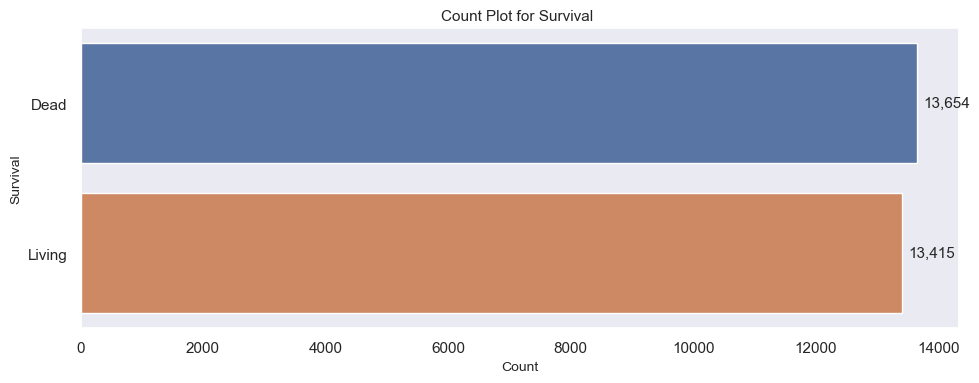

In [6]:
# create 'Survival' column using .loc[]
df.loc[:, 'Survival'] = np.where(pd.isna(df['TransplantSurvivalDay']), np.nan, df['TransplantSurvivalDay'] >= 1095)

# map boolean values to descriptive labels
df['Survival'] = df['Survival'].map({1: 'Living', 0: 'Dead'}, na_action='ignore')

# plot
uv.countPlot(df, ['Survival'], figsize=(10, 4))

In [8]:
# sanity check
uf.datatypeDF(df, display=True)

Total Data feature count:  233

Boolean feature count: 0
Category feature count: 75
Numeric feature count: 56
Object feature count: 102
Other feature count: 0

Total feature count:  233


###  Display NaNs

In [9]:
# display NaNs
uf.percentageNull(df)

,percentage,NaNCount
Hemodynamics_Addition_Addition_CAN,4.993817,1373
Hemodynamics_Addition_Mean_CAN,4.993817,1373
Hemodynamics_Addition_PCW_CAN,4.106350,1129
Hemodynamics_Mean_PCW_CAN,4.106350,1129
HemodynamicsRegistration_PCW_CAN,3.680803,1012
HemodynamicsTransplant_PCW_CAN,3.680803,1012
LengthOfStay,3.226158,887
Hemodynamics_Mean_CO_CAN,2.265949,623
HemodynamicsTransplant_CO_CAN,2.265949,623
HemodynamicsRegistration_CO_CAN,2.265949,623


### Discretization / Remove Features

#### User Function(s)

In [10]:
def discretization(feature, newFeature, qcut, labelTxt):
    # use quartile bin
    _, bins = pd.qcut(df[feature].dropna(), q=qcut, retbins=True, precision=0)
    
    # create custom labels
    labels = [f'{labelTxt}({int(bins[i])}-{int(bins[i+1])})' for i in range(len(bins)-1)]
    
    # create the categorical column, initially with NaN for missing values
    df[newFeature] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)
    
    # replace NaN with 'Unknown'
    df[newFeature] = df[newFeature].cat.add_categories('Unknown').fillna('Unknown')

    return newFeature

#### Test of Independence for Categorical Variables
- Null Hypothesis (H0): The two variables are not related.
- Alternative Hypothesis (H1): The two variables are related.
- A low p-value (typically < 0.05) indicates a significant relationship between the variables.
- This is the Chi-Square test statistic. It measures the discrepancy between the observed and expected frequencies under the assumption that the variables are independent.
    - A larger `chi2` value indicates a greater difference between observed and expected counts, suggesting that the variables are more likely to be associated.
    - A small p_value (typically < 0.05) suggests that you can reject the null hypothesis and conclude that there is a significant association between the two variables.

#### Cramer's V values can be interpreted as:
- Cramer's V is a measure of association between two nominal (categorical) variables, based on the Chi-Square statistic and varies from `0` (corresponding to no association between the variables) to `1` (complete association) and can reach 1 only when each variable is completely determined by the other.
    - 0.00 to 0.10: Negligible association
    - 0.10 to 0.30: Weak association
    - 0.30 to 0.50: Moderate association
    - 0.50 to 0.70: Strong association
    - 0.70 to 1.00: Very strong association

#### Numeric

In [11]:
print(sorted(df_numeric.column.to_list()))

['Age_Addition', 'Age_CAN', 'Age_DON', 'BMI_Addition', 'BMI_CAN', 'BMI_DON', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'CreatinineRegistration_CAN', 'CreatinineTransplant_CAN', 'Creatinine_Addition', 'Creatinine_Addition_CAN', 'Creatinine_DON', 'Creatinine_Mean_CAN', 'DistanceFromDonorHospitaltoTXCenter', 'HeightCm_Addition', 'HeightCm_CAN', 'HeightCm_DON', 'Hematocrit_DON', 'HemodynamicsRegistration_CO_CAN', 'HemodynamicsRegistration_PA_DIA_CAN', 'HemodynamicsRegistration_PA_MN_CAN', 'HemodynamicsRegistration_PCW_CAN', 'HemodynamicsRegistration_SYS_CAN', 'HemodynamicsTransplant_CO_CAN', 'HemodynamicsTransplant_PA_DIA_CAN', 'HemodynamicsTransplant_PA_MN_CAN', 'HemodynamicsTransplant_PCW_CAN', 'HemodynamicsTransplant_SYS_CAN', 'Hemodynamics_Addition_Addition_CAN', 'Hemodynamics_Addition_CO_CAN', 'Hemodynamics_Addition_Mean_CAN', 'Hemodynamics_Addition_PA_DIA_CAN', 'Hemodynamics_Addition_PA_MN_CAN', 'Hemodynamics_Addition_PCW_CAN', 'Hemodynamics_Addition_SYS_CAN', 'Hemodynamics_Mean_C

##### Age

In [12]:
features = uf.getFeatureList(df, 'Age_')

                count       mean        std   min   25%   50%   75%    max
Age_Addition  27494.0  85.555321  18.105133  26.0  75.0  86.0  98.0  138.0
Age_CAN       27494.0  53.411872  12.903775  18.0  46.0  56.0  63.0   79.0
Age_DON       27494.0  32.143449  10.943097   8.0  23.0  31.0  40.0   72.0

:::: NaN Count:
Age_Addition    0
Age_CAN         0
Age_DON         0


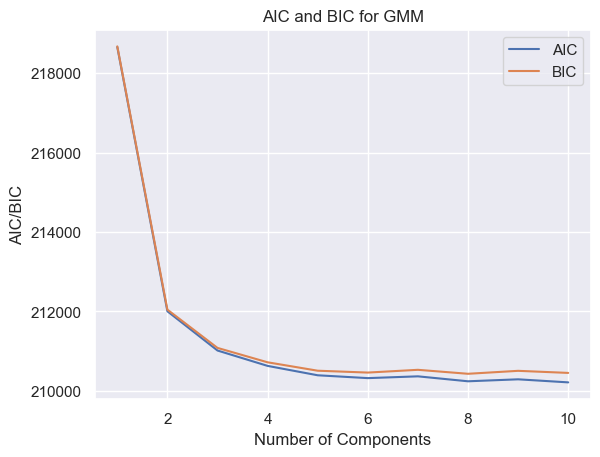

In [13]:
uif.GaussianMixtureBinning(df, ['Age_CAN'], RANDOM_STATE)

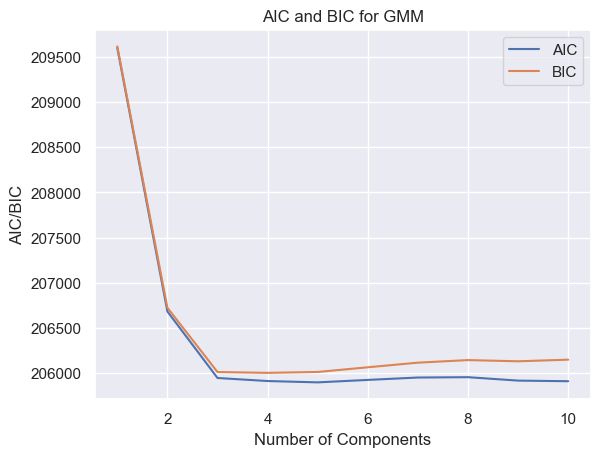

In [14]:
uif.GaussianMixtureBinning(df, ['Age_DON'], RANDOM_STATE)

In [15]:
# removeCols
removeCols = features
# new category feature
newCol = discretization('Age_CAN', 'Age_CAT_CAN', 3, 'Age')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_can = uf.insertIntoDataFrame(df_can, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
Age(18-51),4869.0,4735.0,9604.0,50.697626,49.302374
Age(51-61),4399.0,4471.0,8870.0,49.594138,50.405862
Age(61-79),4386.0,4209.0,8595.0,51.029668,48.970332
Unknown,0.0,0.0,0.0,NaN,NaN
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [16]:
# new category feature
newCol = discretization('Age_DON', 'Age_CAT_DON', 3, 'Age')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_don = uf.insertIntoDataFrame(df_don, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
Age(8-26),4534.0,5319.0,9853.0,46.016442,53.983558
Age(26-36),4470.0,3727.0,8197.0,54.532146,45.467854
Age(36-72),4650.0,4369.0,9019.0,51.557822,48.442178
Unknown,0.0,0.0,0.0,NaN,NaN
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [BMI](https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html)
- The standard BMI ranges for adults are:
    - Underweight: BMI less than 18.5 kg/m²
    - Normal weight: BMI 18.5 to 24.9 kg/m²
    - Overweight: BMI 25 to 29.9 kg/m²
    - Obesity: BMI 30 kg/m² or greater
    - BMI = Weight (kg) / Height (m)²

In [17]:
def categorizeBMI(value):
    """
    Define the function for mapping
    """
    if value < 18.5:
        return "Under Weight"
    elif 18.5 <= value <= 24.9:
        return "Normal Weight"        
    elif 24.9 <= value <= 29.9:
        return "Over Weight"
    elif value >= 29.9:
        return "Obesity"
    else:
        return "Unknown"

##### HeightCm

In [18]:
features = uf.getFeatureList(df, 'HeightCm')

                count        mean        std    min    25%    50%    75%    max
HeightCm_CAN  27494.0  173.647378  10.039060  124.0  167.6  175.0  180.3  213.4
HeightCm_DON  27494.0  173.903143   9.578505  115.0  167.6  175.0  180.3  213.0

:::: NaN Count:
HeightCm_CAN    0
HeightCm_DON    0


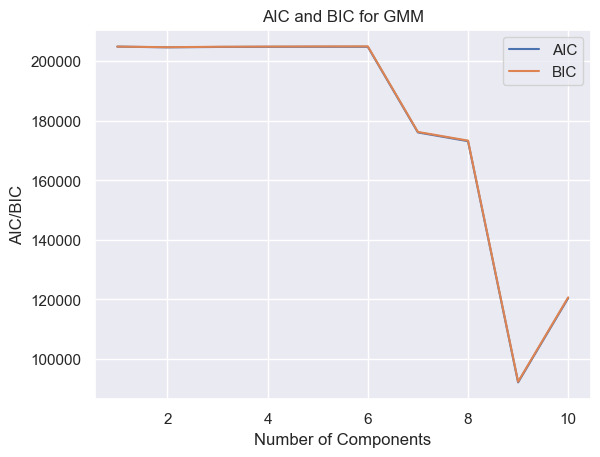

In [19]:
uif.GaussianMixtureBinning(df, ['HeightCm_CAN'], RANDOM_STATE)

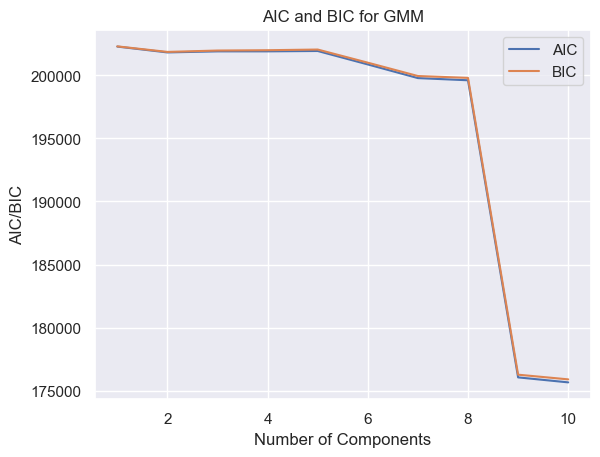

In [20]:
uif.GaussianMixtureBinning(df, ['HeightCm_DON'], RANDOM_STATE)

In [21]:
# removeCols
removeCols.extend(features)
# new category feature
newCol = discretization('HeightCm_CAN', 'HeightCm_CAT_CAN', 9, 'HeightCm')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_can = uf.insertIntoDataFrame(df_can, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
HeightCm(124-160),1655.0,1540.0,3195.0,51.799687,48.200313
HeightCm(160-165),1553.0,1493.0,3046.0,50.984898,49.015102
HeightCm(165-170),2285.0,2312.0,4597.0,49.706330,50.293670
HeightCm(170-172),1168.0,1187.0,2355.0,49.596603,50.403397
HeightCm(172-175),1309.0,1370.0,2679.0,48.861515,51.138485
HeightCm(175-177),1348.0,1247.0,2595.0,51.946050,48.053950
HeightCm(177-182),2310.0,2327.0,4637.0,49.816692,50.183308
HeightCm(182-185),696.0,740.0,1436.0,48.467967,51.532033
HeightCm(185-213),1330.0,1199.0,2529.0,52.589957,47.410043
Unknown,0.0,0.0,0.0,NaN,NaN


In [22]:
# new category feature
newCol = discretization('HeightCm_DON', 'HeightCm_CAT_DON', 9, 'HeightCm')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_don = uf.insertIntoDataFrame(df_don, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
HeightCm(115-162),1672.0,1794.0,3466.0,48.240046,51.759954
HeightCm(162-166),1344.0,1238.0,2582.0,52.052672,47.947328
HeightCm(166-170),1775.0,1753.0,3528.0,50.311791,49.688209
HeightCm(170-173),1602.0,1749.0,3351.0,47.806625,52.193375
HeightCm(173-175),1261.0,1151.0,2412.0,52.280265,47.719735
HeightCm(175-178),1569.0,1531.0,3100.0,50.612903,49.387097
HeightCm(178-182),1675.0,1798.0,3473.0,48.229197,51.770803
HeightCm(182-185),1403.0,1046.0,2449.0,57.288689,42.711311
HeightCm(185-213),1353.0,1355.0,2708.0,49.963072,50.036928
Unknown,0.0,0.0,0.0,NaN,NaN


##### WeightKg

In [23]:
features = uf.getFeatureList(df, 'WeightKg')

                count       mean        std   min   25%   50%   75%    max
WeightKg_CAN  27487.0  83.252636  18.099450  29.9  70.3  82.6  95.3  159.1
WeightKg_DON  27490.0  83.497006  19.548529  23.2  70.0  80.7  94.0  198.0

:::: NaN Count:
WeightKg_CAN    7
WeightKg_DON    4


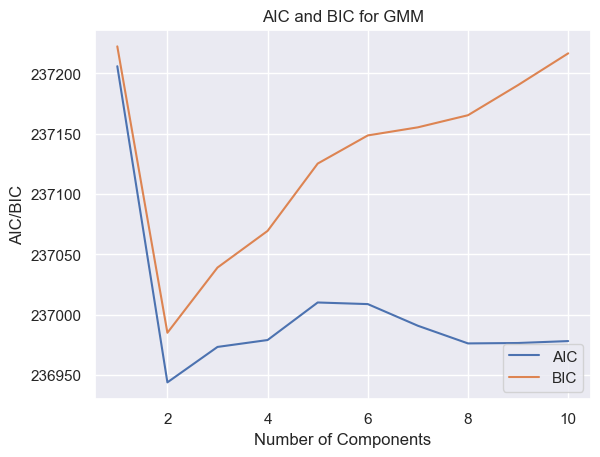

In [24]:
uif.GaussianMixtureBinning(df, ['WeightKg_CAN'], RANDOM_STATE)

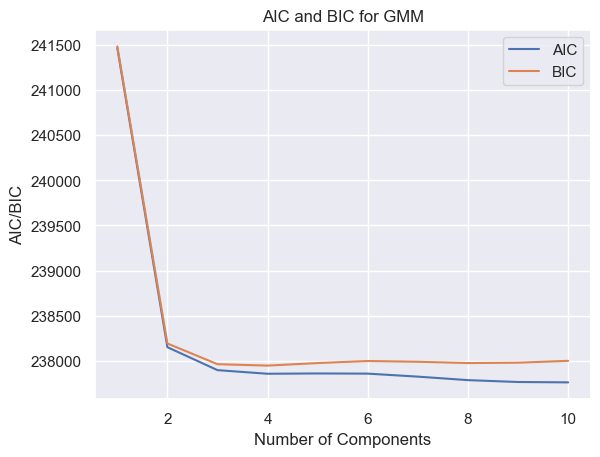

In [25]:
uif.GaussianMixtureBinning(df, ['WeightKg_DON'], RANDOM_STATE)

In [26]:
# removeCols
removeCols.extend(features)
# new category feature
newCol = discretization('WeightKg_CAN', 'WeightKg_CAT_CAN', 2, 'WeightKg')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_can = uf.insertIntoDataFrame(df_can, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
WeightKg(29-82),6744.0,7014.0,13758.0,49.018753,50.981247
WeightKg(82-159),6907.0,6397.0,13304.0,51.916717,48.083283
Unknown,3.0,4.0,7.0,42.857143,57.142857
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [27]:
# new category feature
newCol = discretization('WeightKg_DON', 'WeightKg_CAT_DON', 3, 'WeightKg')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_don = uf.insertIntoDataFrame(df_don, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
WeightKg(23-73),4398.0,4700.0,9098.0,48.340295,51.659705
WeightKg(73-89),4569.0,4502.0,9071.0,50.369309,49.630691
WeightKg(89-198),4686.0,4211.0,8897.0,52.669439,47.330561
Unknown,1.0,2.0,3.0,33.333333,66.666667
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### BMI

In [28]:
features = uf.getFeatureList(df, 'BMI_')

           count       mean       std        min        25%        50%        75%        max
BMI_CAN  27487.0  27.469464  4.869194  14.005023  23.872358  27.232745  30.996140  48.683517
BMI_DON  27490.0  27.592195  6.064454  13.128277  23.381204  26.543288  30.666786  74.321284

:::: NaN Count:
BMI_CAN    7
BMI_DON    4


In [29]:
# create New feature
df['BMI_CAT_CAN'] = df['BMI_CAN'].apply(categorizeBMI)
df['BMI_CAT_DON'] = df['BMI_DON'].apply(categorizeBMI)

# category datatype
df['BMI_CAT_CAN'] = df['BMI_CAT_CAN'].astype('category')
df['BMI_CAT_DON'] = df['BMI_CAT_DON'].astype('category')

# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['BMI_CAT_CAN', 'BMI_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['BMI_CAT_DON'])
df_can = uf.insertIntoDataFrame(df_can, ['BMI_CAT_CAN'])

# add to list
removeCols.extend(features)

In [30]:
uf.categoryContingencySurvival(df, 'BMI_CAT_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
Normal Weight,3917.0,4295.0,8212.0,47.698490,52.301510
Obesity,4565.0,3933.0,8498.0,53.718522,46.281478
Over Weight,4896.0,4878.0,9774.0,50.092081,49.907919
Under Weight,273.0,305.0,578.0,47.231834,52.768166
Unknown,3.0,4.0,7.0,42.857143,57.142857
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [31]:
uf.categoryContingencySurvival(df, 'BMI_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
Normal Weight,4670.0,4869.0,9539.0,48.956914,51.043086
Obesity,4063.0,3634.0,7697.0,52.786800,47.213200
Over Weight,4670.0,4654.0,9324.0,50.085800,49.914200
Under Weight,250.0,256.0,506.0,49.407115,50.592885
Unknown,1.0,2.0,3.0,33.333333,66.666667
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [BloodPH](https://www.ncbi.nlm.nih.gov/books/NBK507807/)
- The normal blood pH range is indeed between 7.35 and 7.45. This slightly alkaline range is crucial for the proper functioning of enzymes and other biochemical reactions in the body.
    - A blood pH below 7.35 is considered acidic, and it can lead to a condition called acidosis. Acidosis can disrupt cellular functions and impair organ systems, particularly the cardiovascular and respiratory systems.
    - A blood pH above 7.45 is considered alkaline, and it can lead to a condition called alkalosis. Alkalosis can cause symptoms such as muscle twitching, hand tremors, and confusion.

In [32]:
def categorizePH(value):
    """
    Define the function for mapping
    """
    if value < 7.35:
        return "Acidic"
    elif value > 7.45:
        return "Alkaline"        
    elif 7.35 <= value <= 7.45:
        return "Normal"
    else:
        return "Unknown"

In [33]:
features = uf.getFeatureList(df, 'BloodPH')

               count      mean    std  min   25%   50%   75%   max
BloodPH_DON  27267.0  7.416161  0.074  5.0  7.38  7.42  7.46  7.93

:::: NaN Count:
BloodPH_DON    227


In [34]:
# create New feature
df['BloodPH_CAT_DON'] = df['BloodPH_DON'].apply(categorizePH)

# category datatype
df['BloodPH_CAT_DON'] = df['BloodPH_CAT_DON'].astype('category')

# update DataFrame
df_nominal = uf.insertIntoDataFrame(df_nominal, ['BloodPH_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['BloodPH_CAT_DON'])

# add to list
removeCols.extend(features)

In [35]:
uf.categoryContingencySurvival(df, 'BloodPH_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
Acidic,1623.0,1744.0,3367.0,48.203148,51.796852
Alkaline,3852.0,3567.0,7419.0,51.920744,48.079256
Normal,8126.0,8084.0,16210.0,50.129550,49.870450
Unknown,53.0,20.0,73.0,72.602740,27.397260
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [BloodUreaNitrogenLevel](https://redcliffelabs.com/myhealth/lab-test/urea-normal-range-causes-procedure-and-treatment/)
- Blood Urea Nitrogen (BUN) is a common blood test that measures the amount of urea nitrogen in the blood, which is a waste product formed from the breakdown of proteins.
    - Source report a range of 8 to 24 mg/dL for adult men and 6 to 21 mg/dL for adult women. 

In [36]:
def categorizeBUN(value, gender):
    """
    Define the function for mapping Blood Urea Nitrogen levels based on value and gender.
    """
    if (0.8 <= value <= 24 and gender == 'M') or (6 <= value <= 21 and gender == 'F'):
        return 'Normal'
    elif (value < 0.8 and gender == 'M') or (value < 6 and gender == 'F'):
        return "Low"
    elif (value > 24 and gender == 'M') or (value > 21 and gender == 'F'):
        return "High"
    else:
        return "Unknown"

In [37]:
features = uf.getFeatureList(df, 'BloodUreaNitrogenLevel_DON')

                              count       mean        std  min   25%   50%   75%    max
BloodUreaNitrogenLevel_DON  27291.0  24.272559  20.110485  0.5  12.0  18.0  29.0  250.0

:::: NaN Count:
BloodUreaNitrogenLevel_DON    203


In [38]:
# create new feature
df['BloodUreaNitrogenLevel_CAT_DON'] = df.apply(lambda row: categorizeBUN(row['BloodUreaNitrogenLevel_DON'], row['Gender_DON']), axis=1)

# category datatype
df['BloodUreaNitrogenLevel_CAT_DON'] = df['BloodUreaNitrogenLevel_CAT_DON'].astype('category')

# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['BloodUreaNitrogenLevel_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['BloodUreaNitrogenLevel_CAT_DON'])

# add to list
removeCols.extend(features)

In [39]:
uf.categoryContingencySurvival(df, 'BloodUreaNitrogenLevel_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
High,5496.0,3747.0,9243.0,59.461214,40.538786
Low,117.0,217.0,334.0,35.029940,64.970060
Normal,8006.0,9436.0,17442.0,45.900699,54.099301
Unknown,35.0,15.0,50.0,70.000000,30.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [Creatinine](https://johnshopkinshealthcare.staywellsolutionsonline.com/BreatheEasy/167,creatinine_serum)
- Creatinine is a waste product that forms when creatine, a substance found in your muscles, breaks down. It's usually filtered out of the blood by the kidneys and excreted in urine. Measuring creatinine levels in the blood can help assess kidney function.
    - Normal
        - 0.7 to 1.3 mg/dL for adult males
        - 0.5 to 1.1 mg/dL for adult females
- High creatinine levels can indicate kidney dysfunction, dehydration, or other conditions affecting the kidneys. If you have concerns about your creatinine levels, it's best to consult with a healthcare professional for proper evaluation and guidance.

In [40]:
def categorizeCR(value, gender):
    """
    Define the function for mapping creatinine levels based on value and gender.
    """
    if (0.7 <= value <= 1.3 and gender == 'M') or (0.5 <= value <= 1.1 and gender == 'F'):
        return 'Normal'
    elif (value < 0.7 and gender == 'M') or (value < 0.5 and gender == 'F'):
        return "Low"
    elif (value > 1.3 and gender == 'M') or (value > 1.1 and gender == 'F'):
        return "Elevated"
    else:
        return "Unknown"

In [41]:
features = uf.getFeatureList(df, 'Creatinine')

                              count      mean       std   min   25%  50%  75%   max
CreatinineRegistration_CAN  27421.0  1.365893  0.963460  0.08  0.94  1.2  1.5  24.0
CreatinineTransplant_CAN    27421.0  1.374737  1.010438  0.06  0.94  1.2  1.5  37.0
Creatinine_DON              27291.0  1.505226  1.557918  0.04  0.76  1.0  1.5  23.0

:::: NaN Count:
CreatinineRegistration_CAN     73
CreatinineTransplant_CAN       73
Creatinine_DON                203


In [42]:
df.groupby('Gender_DON', observed=False)['Creatinine_DON'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender_DON,,,,,,,,
F,8023.0,1.295154,1.337294,0.04,0.62,0.81,1.30,15.0
M,19268.0,1.592697,1.633143,0.05,0.80,1.07,1.53,23.0


In [43]:
# create new feature
df['Creatinine_Mean_CAN'] = df[['CreatinineRegistration_CAN','CreatinineTransplant_CAN']].mean(axis=1)

# update PanelReactiveAntibody_CPRA_CAN with non-NaN values from CreatinineRegistration_CAN and CreatinineTransplant_CAN
df['Creatinine_Mean_CAN'] = df['Creatinine_Mean_CAN'].fillna(df['CreatinineRegistration_CAN'].combine_first(df['CreatinineTransplant_CAN']))

In [44]:
# create new feature
df['Creatinine_CAT_CAN'] = df.apply(lambda row: categorizeCR(row['Creatinine_Mean_CAN'], row['Gender_CAN']), axis=1)
df['Creatinine_CAT_DON'] = df.apply(lambda row: categorizeCR(row['Creatinine_DON'], row['Gender_DON']), axis=1)
                                    
# category datatype
df['Creatinine_CAT_CAN'] = df['Creatinine_CAT_CAN'].astype('category')

# update dataframe
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['Creatinine_CAT_CAN', 'Creatinine_CAT_DON'])
df_can = uf.insertIntoDataFrame(df_can, ['Creatinine_CAT_CAN'])
df_don = uf.insertIntoDataFrame(df_don, ['Creatinine_CAT_DON'])

# add to list
removeCols.extend(features)
removeCols.extend(['Creatinine_Mean_CAN'])

In [45]:
uf.categoryContingencySurvival(df, 'Creatinine_CAT_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
Elevated,6148.0,5476.0,11624.0,52.890571,47.109429
Low,205.0,172.0,377.0,54.376658,45.623342
Normal,7280.0,7767.0,15047.0,48.381737,51.618263
Unknown,21.0,0.0,21.0,100.000000,0.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [46]:
uf.categoryContingencySurvival(df, 'Creatinine_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
Elevated,4616.0,3934.0,8550.0,53.988304,46.011696
Low,1440.0,1245.0,2685.0,53.631285,46.368715
Normal,7563.0,8221.0,15784.0,47.915611,52.084389
Unknown,35.0,15.0,50.0,70.000000,30.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### DistanceFromDonorHospitaltoTXCenter

In [47]:
features = uf.getFeatureList(df, 'DistanceFromDonorHospitaltoTXCenter')

                                       count        mean         std  min   25%    50%    75%     max
DistanceFromDonorHospitaltoTXCenter  27494.0  201.527351  222.020998  0.0  21.0  128.0  322.0  2215.0

:::: NaN Count:
DistanceFromDonorHospitaltoTXCenter    0


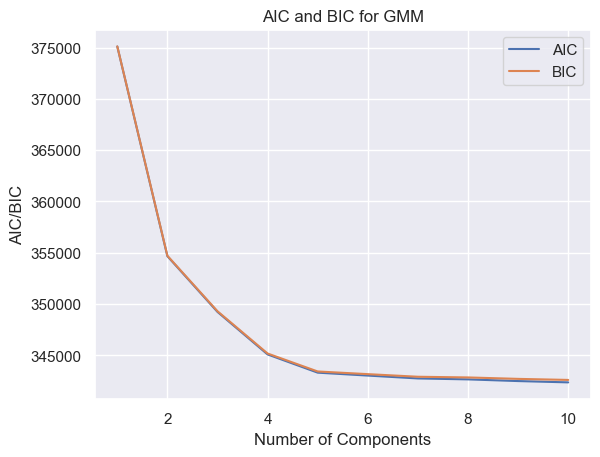

In [48]:
uif.GaussianMixtureBinning(df, ['DistanceFromDonorHospitaltoTXCenter'], RANDOM_STATE)

In [49]:
# add to list
removeCols.extend(features)
# new category feature
newCol = discretization('DistanceFromDonorHospitaltoTXCenter', 'DistanceFromDonorHospitaltoTXCenter_CAT', 4, 'Distance Miles')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_both = uf.insertIntoDataFrame(df_both, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
Distance Miles(0-21),2487.0,4361.0,6848.0,36.317173,63.682827
Distance Miles(21-128),3037.0,3749.0,6786.0,44.753905,55.246095
Distance Miles(128-322),3986.0,2753.0,6739.0,59.148242,40.851758
Distance Miles(322-2215),4144.0,2552.0,6696.0,61.887694,38.112306
Unknown,0.0,0.0,0.0,NaN,NaN
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [Hematocrit_DON](https://www.mountsinai.org/health-library/tests/hematocrit)
- Hematocrit is a blood test that measures how much of a person's blood is made up of red blood cells as opposed to plasma.
    - Normal results vary, but in general they are:
        - Male: 40.7% to 50.3%
        - Female: 36.1% to 44.3% 

In [50]:
def categorizeH(value, gender):
    """
    Define the function for mapping Hematocrit levels based on value and gender.
    """
    if (40.7 <= value <= 50.3 and gender == 'M') or (36.1 <= value <= 44.3 and gender == 'F'):
        return 'Normal'
    elif (value < 40.7 and gender == 'M') or (value < 36.1 and gender == 'F'):
        return "Low"
    elif (value > 50.3 and gender == 'M') or (value > 44.3 and gender == 'F'):
        return "Elevated"
    else:
        return "Unknown"

In [51]:
features = uf.getFeatureList(df, 'Hematocrit')

                  count       mean     std  min   25%   50%   75%   max
Hematocrit_DON  27291.0  28.397493  5.0099  2.3  25.0  27.9  31.3  75.0

:::: NaN Count:
Hematocrit_DON    203


In [52]:
# create new feature
df['Hematocrit_CAT_DON'] = df.apply(lambda row: categorizeH(row['Hematocrit_DON'], row['Gender_DON']), axis=1)
                                    
# category datatype
df['Hematocrit_CAT_DON'] = df['Hematocrit_CAT_DON'].astype('category')

# update dataframe
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['Hematocrit_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['Hematocrit_CAT_DON'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Hematocrit_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
Elevated,14.0,21.0,35.0,40.000000,60.000000
Low,13324.0,12973.0,26297.0,50.667377,49.332623
Normal,281.0,406.0,687.0,40.902475,59.097525
Unknown,35.0,15.0,50.0,70.000000,30.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Hemodynamics
- [CO (Cardiac Output)](https://www.ncbi.nlm.nih.gov/books/NBK470455/#:~:text=Cardiac%20output%20in%20humans%20is,to%20100%20times%20each%20minute.):
    - Definition: Similar to the registration phase, it measures the heart's output during the transplant phase.
    - Importance: Critical for ensuring adequate perfusion during surgery.
    - Cardiac output in humans is generally 5-6 L/min
- [PA_DIA (Pulmonary Artery Diastolic Pressure)](https://www.ncbi.nlm.nih.gov/books/NBK209987/):
    - Definition: Monitored to assess right heart function and pulmonary circulation during transplant.
- [PA_MN (Pulmonary Artery Mean Pressure)](https://www.ncbi.nlm.nih.gov/books/NBK209987/):
    - Definition: Helps in evaluating pulmonary hypertension and right ventricular function.
    - Severe pulmonary hypertension artery pressure of 40 mm Hg or greater
    - Moderate pulmonary hypertension artery pressure between 25 and 39 mm Hg
    - Normal pulmonary artery pressure between 11 and 25 mm Hg
- [PCW (Pulmonary Capillary Wedge Pressure)](https://pubmed.ncbi.nlm.nih.gov/24268673/):
    - Definition: Used to monitor left ventricular function and fluid status during transplant.
- [SYS (Systemic Arterial Pressure)](https://www.ncbi.nlm.nih.gov/books/NBK538509/):
    - Definition: Monitored to ensure stable blood pressure and perfusion during transplant.

In [53]:
def categorizeCO(value):
    """
    Define the function for mapping Hemodynamics levels.
    """
    if value < 5:
        return "Low"
    elif value > 6:
        return "High"    
    if 5 <= value <= 6:
        return "Normal"
    else:
        return "Unknown"

def categorizePA(value):
    """
    Define the function for mapping Hemodynamics levels.
    """
    if value < 11:
        return 'Low'
    elif 11 <= value <= 25:
        return "Normal"
    elif 25 <= value <= 40:
        return "High"
    elif value >= 40:
        return "Extreme"
    else:
        return "Unknown"

In [54]:
features = uf.getFeatureList(df, 'Hemodynamics')

                                       count       mean        std   min    25%    50%     75%    max
HemodynamicsRegistration_CO_CAN      26871.0   4.277981   1.359766  0.39   3.33   4.12   5.010   15.0
HemodynamicsRegistration_PA_DIA_CAN  27018.0  20.443601   8.686121  0.00  14.00  20.00  26.000   91.0
HemodynamicsRegistration_PA_MN_CAN   26989.0  28.504873  10.212890  0.00  21.00  28.00  36.000   96.0
HemodynamicsRegistration_PCW_CAN     26482.0  19.101427   8.833046  0.00  12.00  19.00  25.000   50.0
HemodynamicsRegistration_SYS_CAN     27026.0  41.843262  14.246614  0.00  31.00  41.00  51.000  130.0
HemodynamicsTransplant_CO_CAN        26871.0   4.521705   1.459440  0.20   3.50   4.37   5.315   15.0
HemodynamicsTransplant_PA_DIA_CAN    27018.0  19.174484   8.495244  0.00  13.00  18.00  25.000  110.0
HemodynamicsTransplant_PA_MN_CAN     26989.0  27.029869   9.939695  0.00  20.00  26.00  34.000  110.0
HemodynamicsTransplant_PCW_CAN       26482.0  17.886634   8.720483  0.00  11.00  1

In [55]:
# mean (Registration & Transplant)
df['Hemodynamics_Mean_CO_CAN'] = df[['HemodynamicsRegistration_CO_CAN', 'HemodynamicsTransplant_CO_CAN']].mean(axis=1)
df['Hemodynamics_Mean_PA_DIA_CAN'] = df[['HemodynamicsRegistration_PA_DIA_CAN', 'HemodynamicsTransplant_PA_DIA_CAN']].mean(axis=1)
df['Hemodynamics_Mean_PA_MN_CAN'] = df[['HemodynamicsRegistration_PA_MN_CAN', 'HemodynamicsTransplant_PA_MN_CAN']].mean(axis=1)
df['Hemodynamics_Mean_PCW_CAN'] = df[['HemodynamicsRegistration_PCW_CAN', 'HemodynamicsTransplant_PCW_CAN']].mean(axis=1)
df['Hemodynamics_Mean_SYS_CAN'] = df[['HemodynamicsRegistration_SYS_CAN', 'HemodynamicsTransplant_SYS_CAN']].mean(axis=1)

# update Hemodynamics_Mean with non-NaN values from Registration and Transplant
df['Hemodynamics_Mean_CO_CAN'] = df['Hemodynamics_Mean_CO_CAN'].fillna(df['HemodynamicsRegistration_CO_CAN'].combine_first(df['HemodynamicsTransplant_CO_CAN']))
df['Hemodynamics_Mean_PA_DIA_CAN'] = df['Hemodynamics_Mean_PA_DIA_CAN'].fillna(df['HemodynamicsRegistration_PA_DIA_CAN'].combine_first(df['HemodynamicsTransplant_PA_DIA_CAN']))
df['Hemodynamics_Mean_PA_MN_CAN'] = df['Hemodynamics_Mean_PA_MN_CAN'].fillna(df['HemodynamicsRegistration_PA_MN_CAN'].combine_first(df['HemodynamicsTransplant_PA_MN_CAN']))
df['Hemodynamics_Mean_PCW_CAN'] = df['Hemodynamics_Mean_PCW_CAN'].fillna(df['HemodynamicsRegistration_PCW_CAN'].combine_first(df['HemodynamicsTransplant_PCW_CAN']))
df['Hemodynamics_Mean_SYS_CAN'] = df['Hemodynamics_Mean_SYS_CAN'].fillna(df['HemodynamicsRegistration_SYS_CAN'].combine_first(df['HemodynamicsTransplant_SYS_CAN']))

In [56]:
featuresMean = uf.getFeatureList(df, 'Hemodynamics_Mean')

                                count       mean        std   min     25%   50%   75%    max
Hemodynamics_Mean_CO_CAN      26871.0   4.399843   1.244288  0.98   3.535   4.3   5.1   15.0
Hemodynamics_Mean_PA_DIA_CAN  27018.0  19.809042   7.559014  0.00  14.500  19.5  25.0   82.0
Hemodynamics_Mean_PA_MN_CAN   26989.0  27.767371   8.979471  0.00  21.000  27.5  34.0   84.0
Hemodynamics_Mean_PCW_CAN     26482.0  18.494030   7.870584  0.00  13.000  18.0  24.0   50.0
Hemodynamics_Mean_SYS_CAN     27026.0  40.793639  12.565512  1.00  31.500  40.0  49.0  109.0

:::: NaN Count:
Hemodynamics_Mean_CO_CAN         623
Hemodynamics_Mean_PA_DIA_CAN     476
Hemodynamics_Mean_PA_MN_CAN      505
Hemodynamics_Mean_PCW_CAN       1012
Hemodynamics_Mean_SYS_CAN        468


##### Parameters related to pulmonary and systemic pressures (PA_DIA, PA_MN, PCW, SYS) are strongly positively correlated. This means that when one of these pressures increases, the others will also increase; therefore, use PA_MN ONLY.

In [57]:
df[featuresMean].corr()

,Hemodynamics_Mean_CO_CAN,Hemodynamics_Mean_PA_DIA_CAN,Hemodynamics_Mean_PA_MN_CAN,Hemodynamics_Mean_PCW_CAN,Hemodynamics_Mean_SYS_CAN
Hemodynamics_Mean_CO_CAN,1.000000,-0.198045,-0.166285,-0.202598,-0.132364
Hemodynamics_Mean_PA_DIA_CAN,-0.198045,1.000000,0.905881,0.820934,0.800660
Hemodynamics_Mean_PA_MN_CAN,-0.166285,0.905881,1.000000,0.827792,0.921226
Hemodynamics_Mean_PCW_CAN,-0.202598,0.820934,0.827792,1.000000,0.753404
Hemodynamics_Mean_SYS_CAN,-0.132364,0.800660,0.921226,0.753404,1.000000


In [58]:
# create New feature
df['Hemodynamics_Mean_PA_MN_CAT_CAN'] = df['Hemodynamics_Mean_PA_MN_CAN'].apply(categorizePA)
df['Hemodynamics_Mean_CO_CAT_CAN'] = df['Hemodynamics_Mean_CO_CAN'].apply(categorizeCO)

# category datatype
df['Hemodynamics_Mean_PA_MN_CAT_CAN'] = df['Hemodynamics_Mean_PA_MN_CAT_CAN'].astype('category')
df['Hemodynamics_Mean_CO_CAT_CAN'] = df['Hemodynamics_Mean_CO_CAT_CAN'].astype('category')

# update dataframe
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['Hemodynamics_Mean_PA_MN_CAT_CAN', 'Hemodynamics_Mean_CO_CAT_CAN'])
df_can = uf.insertIntoDataFrame(df_can, ['Hemodynamics_Mean_PA_MN_CAT_CAN', 'Hemodynamics_Mean_CO_CAT_CAN'])

# add to list
removeCols.extend(features)
removeCols.extend(featuresMean)

In [59]:
uf.categoryContingencySurvival(df, 'Hemodynamics_Mean_PA_MN_CAT_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
Extreme,1164.0,999.0,2163.0,53.814147,46.185853
High,6614.0,6862.0,13476.0,49.079846,50.920154
Low,180.0,162.0,342.0,52.631579,47.368421
Normal,5447.0,5196.0,10643.0,51.179179,48.820821
Unknown,249.0,196.0,445.0,55.955056,44.044944
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [60]:
uf.categoryContingencySurvival(df, 'Hemodynamics_Mean_CO_CAT_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
High,1289.0,1234.0,2523.0,51.089972,48.910028
Low,9654.0,9385.0,19039.0,50.706445,49.293555
Normal,2390.0,2561.0,4951.0,48.273076,51.726924
Unknown,321.0,235.0,556.0,57.733813,42.266187
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [IschemicTimeHour](https://www.jhltonline.org/article/S1053-2498(23)01819-3/fulltext)
-  The maximum time it can be without blood supply before significant damage occurs, is around 4 hours when preserved in cold storage for transplantation; exceeding this timeframe significantly increases the risk of complications and poor outcomes after transplant. 

In [61]:
def categoryISC(value):
    if value <= 2.6:
        return 'Low'
    elif 2.6 <= value <= 4:
        return 'Normal'
    elif value > 4:
        return 'High'
    else:
        return 'Unknown'

In [62]:
features = uf.getFeatureList(df, 'IschemicTimeHour_DON')

                        count      mean       std  min  25%  50%  75%   max
IschemicTimeHour_DON  26941.0  3.234223  1.070724  0.3  2.5  3.3  3.9  12.0

:::: NaN Count:
IschemicTimeHour_DON    553


In [63]:
# create New feature
df['IschemicTimeHour_CAT'] = df['IschemicTimeHour_DON'].apply(categoryISC)
# category datatype
df['IschemicTimeHour_CAT'] = df['IschemicTimeHour_CAT'].astype('category')

# update dataframe
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['IschemicTimeHour_CAT'])
df_both = uf.insertIntoDataFrame(df_both, ['IschemicTimeHour_CAT'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'IschemicTimeHour_CAT')

Survival,Dead,Living,Row Total,Dead %,Living %
High,2906.0,2099.0,5005.0,58.061938,41.938062
Low,3192.0,4658.0,7850.0,40.662420,59.337580
Normal,7438.0,6599.0,14037.0,52.988530,47.011470
Unknown,118.0,59.0,177.0,66.666667,33.333333
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [LV_EjectionFractionPercent](https://my.clevelandclinic.org/health/articles/16950-ejection-fraction)
- Ejection fraction measures your heart’s ability to pump oxygen-rich blood out to your body. In a healthy heart, the fraction is a higher number. A low number means that your heart has difficulty keeping up with your body’s needs.
    - Male:
        - Nomal: 52% to 72%
        - Mildly Abnormal: 41% to 51%
        - Moderately Abnormal: 30% to 40%
        - Severely Abnormal: Below 30% 
    - Female:
        - Nomal: 54% to 74%
        - Mildly Abnormal: 41% to 53%
        - Moderately Abnormal: 30% to 40%
        - Severely Abnormal: Below 30% 

In [64]:
def categorizeLV(value, gender):
    """
    Define the function for mapping LV Ejection Fraction Percent based on value and gender.
    """
    if (52 <= value <= 72 and gender == 'M') or (54 <= value <= 74 and gender == 'F'):
        return 'Normal'
    elif (41 <= value <= 52 and gender == 'M') or (41 <= value <= 54 and gender == 'F'):
        return "Mildly Abnormal"
    elif (30 <= value <= 41) and gender in ['M', 'F']:
        return "Moderately Abnormal"
    elif (value < 30) and gender in ['M', 'F']:
        return "Severely Abnormal"
    elif (value > 72 and gender == 'M') or (value > 74 and gender == 'F'):
        return 'Below Normal'
    else:
        return "Unknown"

In [65]:
features = uf.getFeatureList(df, 'LV_EjectionFractionPercent_DON')

                                  count       mean       std   min   25%   50%   75%   max
LV_EjectionFractionPercent_DON  27463.0  61.619236  6.645749  10.0  56.0  60.0  65.0  99.0

:::: NaN Count:
LV_EjectionFractionPercent_DON    31


In [66]:
# create new feature
df['LV_EjectionFractionPercent_CAT_DON'] = df.apply(lambda row: categorizeLV(row['LV_EjectionFractionPercent_DON'], row['Gender_DON']), axis=1)

# category datatype
df['LV_EjectionFractionPercent_CAT_DON'] = df['LV_EjectionFractionPercent_CAT_DON'].astype('category')

# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['LV_EjectionFractionPercent_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['LV_EjectionFractionPercent_CAT_DON'])

# add to list
removeCols.extend(features)

In [67]:
df.groupby('Gender_DON', observed=False)['LV_EjectionFractionPercent_CAT_DON'].describe()

,count,unique,top,freq
Gender_DON,,,,
F,8071,6,Normal,7238
M,19423,6,Normal,17294


In [68]:
uf.categoryContingencySurvival(df, 'LV_EjectionFractionPercent_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
Below Normal,647.0,689.0,1336.0,48.428144,51.571856
Mildly Abnormal,672.0,755.0,1427.0,47.091801,52.908199
Moderately Abnormal,55.0,48.0,103.0,53.398058,46.601942
Normal,12258.0,11903.0,24161.0,50.734655,49.265345
Severely Abnormal,11.0,2.0,13.0,84.615385,15.384615
Unknown,11.0,18.0,29.0,37.931034,62.068966
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Level_SGOT
- `SGOT`, also known as aspartate aminotransferase `(AST)`, is an enzyme primarily found in the liver, heart, kidneys, and muscles. It plays a crucial role in amino acid metabolism by catalyzing the transfer of an amino group from aspartate to α-ketoglutarate, producing oxaloacetate and glutamate.
    - Conservative normal range of 8 to 45 units/L for healthy individuals. 
- Alanine aminotransferase `(ALT)`, also known as serum glutamic-pyruvic transaminase `(SGPT)`, is an enzyme primarily found in the liver. It plays a crucial role in amino acid metabolism by catalyzing the conversion of alanine and α-ketoglutarate into pyruvate and glutamate. ALT is commonly measured in blood tests to evaluate liver function and detect liver damage.
    - The typical normal range for ALT is approximately 7 to 56 units per liter (U/L) of serum. However, ranges may vary slightly between laboratories. 

In [69]:
def categoryAST(value):
    if value <= 8:
        return 'Low'
    elif 8 <= value <= 45:
        return 'Normal'
    elif value > 45:
        return 'High'
    else:
        return 'Unknown'


def categoryALT(value):
    if value <= 7:
        return 'Low'
    elif 7 <= value <= 56:
        return 'Normal'
    elif value > 56:
        return 'High'
    else:
        return 'Unknown'

In [70]:
features = uf.getFeatureList(df, 'Level_SGOT')

                      count        mean         std  min   25%   50%   75%      max
Level_SGOT_ALT_DON  27287.0  114.875032  408.872451  3.0  23.0  41.0  83.0  44117.0
Level_SGOT_AST_DON  27287.0  102.015934  302.539273  0.3  26.0  44.0  87.0  10254.0

:::: NaN Count:
Level_SGOT_ALT_DON    207
Level_SGOT_AST_DON    207


In [71]:
df[features].corr()

,Level_SGOT_ALT_DON,Level_SGOT_AST_DON
Level_SGOT_ALT_DON,1.000000,0.556127
Level_SGOT_AST_DON,0.556127,1.000000


In [72]:
# create New feature
df['SOGT_ALT_CAT_DON'] = df['Level_SGOT_ALT_DON'].apply(categoryALT)
df['SOGT_AST_CAT_DON'] = df['Level_SGOT_AST_DON'].apply(categoryAST)
# category datatype
df['SOGT_ALT_CAT_DON'] = df['SOGT_ALT_CAT_DON'].astype('category')
df['SOGT_AST_CAT_DON'] = df['SOGT_AST_CAT_DON'].astype('category')

# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['SOGT_AST_CAT_DON', 'SOGT_ALT_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['SOGT_AST_CAT_DON', 'SOGT_ALT_CAT_DON'])

# add to list
removeCols.extend(features)

In [73]:
uf.categoryContingencySurvival(df, 'SOGT_ALT_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
High,5252.0,4693.0,9945.0,52.810458,47.189542
Low,94.0,103.0,197.0,47.715736,52.284264
Normal,8272.0,8601.0,16873.0,49.025070,50.974930
Unknown,36.0,18.0,54.0,66.666667,33.333333
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [74]:
uf.categoryContingencySurvival(df, 'SOGT_AST_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
High,6636.0,6587.0,13223.0,50.185283,49.814717
Low,98.0,105.0,203.0,48.275862,51.724138
Normal,6884.0,6705.0,13589.0,50.658621,49.341379
Unknown,36.0,18.0,54.0,66.666667,33.333333
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### [OrganRecovery_PCO2_DON](https://www.ncbi.nlm.nih.gov/books/NBK551648/)
- A blood gas test is performed to measure the amount of C02 in the blood. When the lung’s ability to exchange oxygen and C02 becomes impaired, the PC02 level may become increased. The candidate’s current PC02 and change in PC02 are both considered in the lung allocation score calculation to reflect worsening PC02 values. PCO2 is used in the Lung Allocation Score.
- The normal range for the partial pressure of carbon dioxide (pCO2) in arterial blood is typically between 35 to 45 mmHg

In [75]:
def categoryPCO2(value):
    if value < 35:
        return 'Low'
    elif 35 <= value <= 45:
        return 'Normal'
    elif value > 45:
        return 'High'
    else:
        return 'Unknown'

In [76]:
features = uf.getFeatureList(df, 'OrganRecovery_PCO2_DON')

                          count      mean       std   min   25%   50%   75%    max
OrganRecovery_PCO2_DON  27261.0  38.66196  7.050992  10.1  34.0  38.0  42.2  116.3

:::: NaN Count:
OrganRecovery_PCO2_DON    233


In [77]:
# new feature
df['OrganRecovery_PCO2_CAT_DON'] = df.OrganRecovery_PCO2_DON.apply(categoryPCO2)

# category datatype
df['OrganRecovery_PCO2_CAT_DON'] = df['OrganRecovery_PCO2_CAT_DON'].astype('category')

# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['OrganRecovery_PCO2_CAT_DON'])
df_don = uf.insertIntoDataFrame(df_don, ['OrganRecovery_PCO2_CAT_DON'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'OrganRecovery_PCO2_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
High,2067.0,1739.0,3806.0,54.308986,45.691014
Low,3468.0,4162.0,7630.0,45.452163,54.547837
Normal,8061.0,7493.0,15554.0,51.825897,48.174103
Unknown,58.0,21.0,79.0,73.417722,26.582278
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Bilirubin
- Bilirubin levels can be an important factor in heart transplantation, particularly in the context of post-operative outcomes. Elevated bilirubin levels, or hyperbilirubinemia, can indicate liver dysfunction, which is a common complication following cardiac surgery, including heart transplantation.
    - Prognostic Marker: Hyperbilirubinemia is often used as a prognostic marker for adverse outcomes after cardiac surgery. Elevated bilirubin levels are associated with increased in-hospital mortality, prolonged ICU stays, and other complications.
    - Incidence and Risk Factors: The incidence of hyperbilirubinemia after cardiac surgery varies widely, with reports ranging from 8.6% to 40%. Risk factors include the type of surgery, duration of cardiopulmonary bypass, and pre-existing liver conditions.
    - Management: Managing elevated bilirubin levels involves addressing the underlying causes, such as improving liver perfusion and reducing hemolysis. Treatments like bilirubin adsorption and plasma exchange have been studied for their efficacy in reducing bilirubin levels and improving outcomes.
    - Impact on Transplant Outcomes: High bilirubin levels can complicate the post-operative course and affect the overall success of the heart transplant. Monitoring and managing bilirubin levels is crucial for improving patient outcomes. 

In [78]:
features = uf.getFeatureList(df, 'TotalBilirubin')

                                count      mean       std  min  25%  50%  75%   max
TerminalTotalBilirubin_DON    27288.0  1.044261  1.427990  0.0  0.5  0.7  1.1  45.4
TotalBilirubinTransplant_CAN  27041.0  0.995037  1.732819  0.1  0.5  0.7  1.1  80.0

:::: NaN Count:
TerminalTotalBilirubin_DON      206
TotalBilirubinTransplant_CAN    453


In [79]:
def catMapB(value):
    if value <= 1.2:
        return 'Normal'
    elif value > 1.2:
        return 'High'
    else:
        return 'Unknown'

In [80]:
# new features
df['Bilirubin_CAT_CAN'] = df['TotalBilirubinTransplant_CAN'].map(catMapB).fillna(df['TotalBilirubinTransplant_CAN'])
df['Bilirubin_CAT_DON'] = df['TerminalTotalBilirubin_DON'].map(catMapB).fillna(df['TerminalTotalBilirubin_DON'])

# category datatype
df['Bilirubin_CAT_CAN'] = df['Bilirubin_CAT_CAN'].astype('category')
df['Bilirubin_CAT_DON'] = df['Bilirubin_CAT_DON'].astype('category')

# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, ['Bilirubin_CAT_CAN', 'Bilirubin_CAT_DON'])
df_can = uf.insertIntoDataFrame(df_can, ['Bilirubin_CAT_CAN'])
df_don = uf.insertIntoDataFrame(df_don, ['Bilirubin_CAT_DON'])

# add to list
removeCols.extend(features)

In [81]:
uf.categoryContingencySurvival(df, 'Bilirubin_CAT_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
High,2730.0,2389.0,5119.0,53.330729,46.669271
Normal,10861.0,11002.0,21863.0,49.677537,50.322463
Unknown,63.0,24.0,87.0,72.413793,27.586207
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [82]:
uf.categoryContingencySurvival(df, 'Bilirubin_CAT_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
High,2851.0,2922.0,5773.0,49.385068,50.614932
Normal,10767.0,10476.0,21243.0,50.684932,49.315068
Unknown,36.0,17.0,53.0,67.924528,32.075472
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### TotalDayWaitList_CAN

In [83]:
features = uf.getFeatureList(df, 'TotalDayWaitList')

                        count        mean         std  min   25%   50%    75%     max
TotalDayWaitList_CAN  27494.0  192.774314  311.074495  0.0  18.0  69.0  231.0  3835.0

:::: NaN Count:
TotalDayWaitList_CAN    0


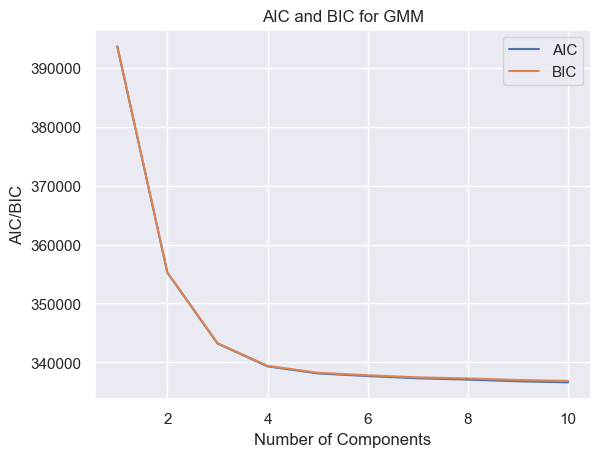

In [84]:
uif.GaussianMixtureBinning(df, features, RANDOM_STATE)

In [85]:
# add to list
removeCols.extend(features)
# new category feature
newCol = discretization('TotalDayWaitList_CAN', 'TotalDayWaitList_CAT_CAN', 4, 'WaitList Days')
# update DataFrame
df_ordinal = uf.insertIntoDataFrame(df_ordinal, [newCol])
df_can = uf.insertIntoDataFrame(df_can, [newCol])
# display
uf.categoryContingencySurvival(df, newCol)

Survival,Dead,Living,Row Total,Dead %,Living %
WaitList Days(0-18),4386.0,2430.0,6816.0,64.348592,35.651408
WaitList Days(18-69),3310.0,3384.0,6694.0,49.447266,50.552734
WaitList Days(69-231),2828.0,3927.0,6755.0,41.865285,58.134715
WaitList Days(231-3835),3130.0,3674.0,6804.0,46.002352,53.997648
Unknown,0.0,0.0,0.0,NaN,NaN
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


#### Remove Unwanted Features

In [86]:
# remove features
df, df_dict, df_label, df_can, df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date = uf.HouseKeeping(df, removeCols, df_dict, df_label, df_can,\
                                                                df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date, txt=REMOVE, display=True)
# initialize
removeCols = []

Data Dictionary Updated.
Remove 0 row(s) from df_label DataFrame.
Remove 20 row(s) from df_can DataFrame.
Remove 13 row(s) from df_don DataFrame.
Remove 0 row(s) from df_both DataFrame.
Remove 0 row(s) from df_ordinal DataFrame.
Remove 0 row(s) from df_nominal DataFrame.
Remove 33 row(s) from df_numeric DataFrame.
Remove 25 row(s) from df_drop DataFrame.
Remove 0 row(s) from df_object DataFrame.
Remove 0 row(s) from df_unknown DataFrame.
Remove 0 row(s) from df_date DataFrame.

Removed Features: ['Age_CAN', 'Age_DON', 'BMI_CAN', 'BMI_DON', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'CreatinineRegistration_CAN', 'CreatinineTransplant_CAN', 'Creatinine_DON', 'Creatinine_Mean_CAN', 'DistanceFromDonorHospitaltoTXCenter', 'HeightCm_CAN', 'HeightCm_DON', 'Hematocrit_DON', 'HemodynamicsRegistration_CO_CAN', 'HemodynamicsRegistration_PA_DIA_CAN', 'HemodynamicsRegistration_PA_MN_CAN', 'HemodynamicsRegistration_PCW_CAN', 'HemodynamicsRegistration_SYS_CAN', 'HemodynamicsTransplant_CO_CAN', 'Hem

#### Nominal

In [87]:
print(sorted(df_nominal.column.to_list()))

['AllocationType_DON', 'AntiHypertensive_DON', 'AntibodyResultHBSAB_DON', 'AntibodyResultRPR_VDRL_DON', 'Antibody_HEP_C_DON', 'AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenC1_CAN', 'AntigenC2_CAN', 'AntigenDA1_DON', 'AntigenDA2_DON', 'AntigenDB1_DON', 'AntigenDB2_DON', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN', 'AntigenDR1_DON', 'AntigenDR2_DON', 'AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN', 'AntigenRA1_CAN', 'AntigenRA2_CAN', 'AntigenRB1_CAN', 'AntigenRB2_CAN', 'AntigenRDR1_CAN', 'AntigenRDR2_CAN', 'ArginnieManagement_DON', 'Biopsy_DON', 'BloodGroupMatchLevel', 'BloodGroup_CAN', 'BloodGroup_DON', 'BloodInfectionSource_DON', 'BloodPH_CAT_DON', 'BronchoscopyLeft_DON', 'BronchoscopyRight_DON', 'CMVStatus_Transplant_CAN', 'CMV_IGG_Transplant_CAN', 'CMV_IGM_Transplant_CAN', 'CancerExtraCranial_DON', 'CancerHistory_DON', 'CancerIntraCranial_DON', 'CancerSkin_DON', 'CardiacArrest_DON', 'CauseOfDeath_DON', 'CerebroVascularDiseas

##### AllocationType_DON

In [88]:
features = uf.getFeatureList(df, 'AllocationType_DON')

                    count unique    top   freq
AllocationType_DON  27494      4  Local  13907

:::: NaN Count:
AllocationType_DON    0


In [89]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival          Dead   Living  Row Total     Dead %   Living %
Foreign Donor     12.0     13.0       25.0  48.000000  52.000000
Local           5070.0   8725.0    13795.0  36.752447  63.247553
National        5304.0   2790.0     8094.0  65.530022  34.469978
Regional        3268.0   1887.0     5155.0  63.394762  36.605238
Column Total   13654.0  13415.0    27069.0  50.441464  49.558536




##### AntiHypertensive_DON

In [90]:
features = uf.getFeatureList(df, 'AntiHypertensive_DON')

                      count unique top   freq
AntiHypertensive_DON  27494      3  No  18224

:::: NaN Count:
AntiHypertensive_DON    0


In [91]:
for feature in features:
    print(uf.categoryContingencySurvival(df, feature, 'Survival'))
    print('\n')

Survival         Dead   Living  Row Total     Dead %   Living %
No             8913.0   9134.0    18047.0  49.387710  50.612290
Unknown          41.0     18.0       59.0  69.491525  30.508475
Yes            4700.0   4263.0     8963.0  52.437800  47.562200
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Antibody

In [92]:
features = uf.getFeatureList(df, 'Antibody')

                                       count unique       top   freq
AntibodyResultHBSAB_DON                27494      3   Unknown  23514
AntibodyResultRPR_VDRL_DON             27494      3  Negative  26751
Antibody_HEP_C_DON                     27494      3  Negative  26048
Hepatitis_B_CoreAntibody_CAN           27494      3  Negative  24587
Hepatitis_B_CoreAntibody_DON           27494      3  Negative  26917
SurfaceHBVAntibodyTotalTransplant_CAN  27494      5  Negative  13383

:::: NaN Count:
AntibodyResultHBSAB_DON                  0
AntibodyResultRPR_VDRL_DON               0
Antibody_HEP_C_DON                       0
Hepatitis_B_CoreAntibody_CAN             0
Hepatitis_B_CoreAntibody_DON             0
SurfaceHBVAntibodyTotalTransplant_CAN    0


In [93]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features).head()

,column1,column2,chi2,p_value,cramer_v
10,Antibody_HEP_C_DON,Hepatitis_B_CoreAntibody_DON,2024.252864,0.000000e+00,0.191866
13,Hepatitis_B_CoreAntibody_CAN,SurfaceHBVAntibodyTotalTransplant_CAN,1840.249468,0.000000e+00,0.182938
3,AntibodyResultHBSAB_DON,Hepatitis_B_CoreAntibody_DON,472.725626,5.300872e-101,0.092719
11,Antibody_HEP_C_DON,SurfaceHBVAntibodyTotalTransplant_CAN,461.792014,1.098730e-94,0.091641
8,AntibodyResultRPR_VDRL_DON,SurfaceHBVAntibodyTotalTransplant_CAN,451.825601,1.502341e-92,0.090647


##### Antigen

###### Antigen CAN

In [94]:
features = uf.getFeatureList(df, '^Antigen.*_CAN')

                   count unique       top   freq
AntigenBW4_CAN     27494      3  Negative  21509
AntigenBW6_CAN     27494      3  Negative  19504
AntigenC1_CAN      27494      2  Negative  18502
AntigenC2_CAN      27494      2  Negative  19309
AntigenDQ1_CAN     27494      2  Negative  18245
AntigenDQ2_CAN     27494      2  Negative  19333
AntigenDR51_2_CAN  27494      3  Negative  25924
AntigenDR51_CAN    27494      3  Negative  19712
AntigenDR52_2_CAN  27494      3  Negative  25828
AntigenDR52_CAN    27494      3  Negative  19139
AntigenDR53_2_CAN  27494      3  Negative  25917
AntigenDR53_CAN    27494      3  Negative  19450
AntigenRA1_CAN     27494      3  Positive  25175
AntigenRA2_CAN     27494      3  Positive  22887
AntigenRB1_CAN     27494      3  Positive  25176
AntigenRB2_CAN     27494      3  Positive  24003
AntigenRDR1_CAN    27494      3  Positive  25176
AntigenRDR2_CAN    27494      3  Positive  23483

:::: NaN Count:
AntigenBW4_CAN       0
AntigenBW6_CAN       0
Antige

In [95]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features).head(20)

,column1,column2,chi2,p_value,cramer_v
148,AntigenRB1_CAN,AntigenRDR1_CAN,54296.863428,0.0,0.993696
141,AntigenRA1_CAN,AntigenRDR1_CAN,54188.876943,0.0,0.992707
139,AntigenRA1_CAN,AntigenRB1_CAN,53999.520500,0.0,0.990971
90,AntigenDR51_2_CAN,AntigenDR53_2_CAN,51360.708023,0.0,0.966455
34,AntigenC1_CAN,AntigenDQ1_CAN,25391.542924,0.0,0.961005
101,AntigenDR51_CAN,AntigenDR53_CAN,48690.586602,0.0,0.940998
109,AntigenDR52_2_CAN,AntigenDR53_2_CAN,48567.291629,0.0,0.939805
88,AntigenDR51_2_CAN,AntigenDR52_2_CAN,48539.519175,0.0,0.939537
99,AntigenDR51_CAN,AntigenDR52_CAN,48357.794019,0.0,0.937776
33,AntigenC1_CAN,AntigenC2_CAN,23871.834461,0.0,0.931803


In [96]:
# new feature
df['Antigen_Positive_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['Antigen_Positive_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Antigen_Positive_Count_CAN'])

# add to list
removeCols.extend(features)

In [97]:
uf.categoryContingencySurvival(df, 'Antigen_Positive_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,1098.0,1110.0,2208.0,49.728261,50.271739
2,0.0,2.0,2.0,0.000000,100.000000
3,40.0,41.0,81.0,49.382716,50.617284
4,126.0,203.0,329.0,38.297872,61.702128
5,977.0,1378.0,2355.0,41.486200,58.513800
6,6367.0,6209.0,12576.0,50.628181,49.371819
7,20.0,71.0,91.0,21.978022,78.021978
8,57.0,125.0,182.0,31.318681,68.681319
9,95.0,145.0,240.0,39.583333,60.416667
10,103.0,193.0,296.0,34.797297,65.202703


###### Antigen DON

In [98]:
features = uf.getFeatureList(df, '^Antigen.*_DON')

                count unique       top   freq
AntigenDA1_DON  27494      2  Positive  27491
AntigenDA2_DON  27494      3  Positive  25224
AntigenDB1_DON  27494      2  Positive  27491
AntigenDB2_DON  27494      3  Positive  26289
AntigenDR1_DON  27494      2  Positive  27489
AntigenDR2_DON  27494      3  Positive  25654

:::: NaN Count:
AntigenDA1_DON    0
AntigenDA2_DON    0
AntigenDB1_DON    0
AntigenDB2_DON    0
AntigenDR1_DON    0
AntigenDR2_DON    0


In [99]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features).head(20)

,column1,column2,chi2,p_value,cramer_v
1,AntigenDA1_DON,AntigenDB1_DON,19092.222140,0.0,0.833315
3,AntigenDA1_DON,AntigenDR1_DON,11454.166500,0.0,0.645450
10,AntigenDB1_DON,AntigenDR1_DON,11454.166500,0.0,0.645450
14,AntigenDR1_DON,AntigenDR2_DON,8082.940535,0.0,0.542208
0,AntigenDA1_DON,AntigenDA2_DON,6342.461287,0.0,0.480297
5,AntigenDA2_DON,AntigenDB1_DON,6342.461287,0.0,0.480297
2,AntigenDA1_DON,AntigenDB2_DON,5496.399738,0.0,0.447116
9,AntigenDB1_DON,AntigenDB2_DON,5496.399738,0.0,0.447116
4,AntigenDA1_DON,AntigenDR2_DON,4849.411495,0.0,0.419977
11,AntigenDB1_DON,AntigenDR2_DON,4849.411495,0.0,0.419977


In [100]:
# new feature
df['Antigen_Positive_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['Antigen_Positive_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Antigen_Positive_Count_DON'])

# add to list
removeCols.extend(features)

In [101]:
uf.categoryContingencySurvival(df, 'Antigen_Positive_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,1.0,2.0,3.0,33.333333,66.666667
3,34.0,87.0,121.0,28.099174,71.900826
4,217.0,407.0,624.0,34.775641,65.224359
5,1492.0,2174.0,3666.0,40.698309,59.301691
6,11910.0,10745.0,22655.0,52.571176,47.428824
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### ArginnieManagement_DON

In [102]:
features = uf.getFeatureList(df, 'Arginnie')

                        count unique  top   freq
ArginnieManagement_DON  27494      3  Yes  18927

:::: NaN Count:
ArginnieManagement_DON    0


In [103]:
uf.categoryContingencySurvival(df, 'ArginnieManagement_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
No,4021.0,4256.0,8277.0,48.580404,51.419596
Unknown,37.0,20.0,57.0,64.912281,35.087719
Yes,9596.0,9139.0,18735.0,51.219642,48.780358
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Biopsy_DON (REMOVE)

In [104]:
features = uf.getFeatureList(df, 'Biopsy')

            count unique              top   freq
Biopsy_DON  27494      4  Biopsy not done  27260

:::: NaN Count:
Biopsy_DON    0


In [105]:
uf.categoryContingencySurvival(df, features)

Survival,Dead,Living,Row Total,Dead %,Living %
Biopsy not done,13608.0,13381.0,26989.0,50.420542,49.579458
Unknown,39.0,20.0,59.0,66.101695,33.898305
"Yes, rejection confirmed",5.0,4.0,9.0,55.555556,44.444444
"Yes, rejection not confirmed",2.0,10.0,12.0,16.666667,83.333333
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [106]:
# add to lis: No Value added
removeCols.extend(features)

##### BloodGroup
- Rremove BloodGroup_CAN & BloodGroup_DON

In [107]:
features = uf.getFeatureList(df, 'BloodGroup')

                      count unique        top   freq
BloodGroupMatchLevel  27494      3  Identical  23463
BloodGroup_CAN        27494      8          A  10918
BloodGroup_DON        27494      8          O  13873

:::: NaN Count:
BloodGroupMatchLevel    0
BloodGroup_CAN          0
BloodGroup_DON          0


In [108]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
2,BloodGroup_CAN,BloodGroup_DON,45584.191883,0.0,0.486675
0,BloodGroupMatchLevel,BloodGroup_CAN,5948.384840,0.0,0.328901
1,BloodGroupMatchLevel,BloodGroup_DON,1635.517069,0.0,0.172462


In [109]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total      Dead %   Living %
Compatible     2023.0   1956.0     3979.0   50.841920  49.158080
Identical     11630.0  11459.0    23089.0   50.370306  49.629694
Incompatible      1.0      0.0        1.0  100.000000   0.000000
Column Total  13654.0  13415.0    27069.0   50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
A              5303.0   5462.0    10765.0  49.261496  50.738504
A1               44.0     23.0       67.0  65.671642  34.328358
A1B               2.0      3.0        5.0  40.000000  60.000000
A2                5.0      2.0        7.0  71.428571  28.571429
A2B               2.0      2.0        4.0  50.000000  50.000000
AB              730.0    809.0     1539.0  47.433398  52.566602
B              2152.0   2025.0     4177.0  51.520230  48.479770
O              5416.0   5089.0    10505.0  51.556402  48.443598
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living 

In [110]:
# add to removeCols
removeCols.extend(['BloodGroup_CAN','BloodGroup_DON'])

##### BloodPH_CAT_DON

In [111]:
features = uf.getFeatureList(df, 'BloodPH')

                 count unique     top   freq
BloodPH_CAT_DON  27494      4  Normal  16363

:::: NaN Count:
BloodPH_CAT_DON    0


In [112]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Acidic         1623.0   1744.0     3367.0  48.203148  51.796852
Alkaline       3852.0   3567.0     7419.0  51.920744  48.079256
Normal         8126.0   8084.0    16210.0  50.129550  49.870450
Unknown          53.0     20.0       73.0  72.602740  27.397260
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Bronchoscopy
- BronchoscopyLeft_DON & BronchoscopyRight_DON
- New Feature Bronchoscopy_Combined

In [113]:
features = uf.getFeatureList(df, 'Bronchoscopy')

                       count unique      top   freq
BronchoscopyLeft_DON   27494      3  Unknown  14343
BronchoscopyRight_DON  27494      3  Unknown  14560

:::: NaN Count:
BronchoscopyLeft_DON     0
BronchoscopyRight_DON    0


In [114]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,BronchoscopyLeft_DON,BronchoscopyRight_DON,36483.060785,0.0,0.814539


In [115]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Abnormal       1506.0   1764.0     3270.0  46.055046  53.944954
Normal         4802.0   4975.0     9777.0  49.115271  50.884729
Unknown        7346.0   6676.0    14022.0  52.389103  47.610897
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Abnormal       1761.0   1908.0     3669.0  47.996729  52.003271
Normal         4490.0   4672.0     9162.0  49.006767  50.993233
Unknown        7403.0   6835.0    14238.0  51.994662  48.005338
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [116]:
# new feature
df['Bronchoscopy_Abnormal_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Abnormal'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['Bronchoscopy_Abnormal_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Bronchoscopy_Abnormal_Count_DON'])

# add to list
removeCols.extend(features)

In [117]:
uf.categoryContingencySurvival(df, 'Bronchoscopy_Abnormal_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,11637.0,11117.0,22754.0,51.142656,48.857344
1,767.0,924.0,1691.0,45.357776,54.642224
2,1250.0,1374.0,2624.0,47.637195,52.362805
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### CMV

In [118]:
features = uf.getFeatureList(df, 'CMV')

                          count unique       top   freq
CMVStatus_Transplant_CAN  27494      3  Positive  15309
CMV_IGG_Transplant_CAN    27494      3   Unknown  20255
CMV_IGM_Transplant_CAN    27494      3   Unknown  22118
SerologyAntiCMV_DON       27494      3  Positive  16829

:::: NaN Count:
CMVStatus_Transplant_CAN    0
CMV_IGG_Transplant_CAN      0
CMV_IGM_Transplant_CAN      0
SerologyAntiCMV_DON         0


In [119]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
3,CMV_IGG_Transplant_CAN,CMV_IGM_Transplant_CAN,18781.028994,0.000000e+00,0.584421
0,CMVStatus_Transplant_CAN,CMV_IGG_Transplant_CAN,7471.160396,0.000000e+00,0.368604
1,CMVStatus_Transplant_CAN,CMV_IGM_Transplant_CAN,414.227157,2.344317e-88,0.086793
2,CMVStatus_Transplant_CAN,SerologyAntiCMV_DON,30.609040,3.678234e-06,0.023593
4,CMV_IGG_Transplant_CAN,SerologyAntiCMV_DON,10.633153,3.101144e-02,0.013906
5,CMV_IGM_Transplant_CAN,SerologyAntiCMV_DON,5.551353,2.352522e-01,0.010048


In [120]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative       5800.0   5479.0    11279.0  51.422998  48.577002
Positive       7583.0   7692.0    15275.0  49.643208  50.356792
Unknown         271.0    244.0      515.0  52.621359  47.378641
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative        483.0   2416.0     2899.0  16.660918  83.339082
Positive        725.0   3615.0     4340.0  16.705069  83.294931
Unknown       12446.0   7384.0    19830.0  62.763490  37.236510
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative        868.0   4255.0     5123.0  16.943197  83.056803
Positive         50.0    203.0      253.0  19.762846  80.237154
Unknown       12736.0   8957.0    21693.0  58.710183  41.289817
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Ro

In [121]:
features = uf.getFeatureList(df, 'CMV_I')

                        count unique      top   freq
CMV_IGG_Transplant_CAN  27494      3  Unknown  20255
CMV_IGM_Transplant_CAN  27494      3  Unknown  22118

:::: NaN Count:
CMV_IGG_Transplant_CAN    0
CMV_IGM_Transplant_CAN    0


In [122]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,CMV_IGG_Transplant_CAN,CMV_IGM_Transplant_CAN,18781.028994,0.0,0.584421


In [123]:
# new feature
df['CMV_Positive_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['CMV_Positive_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['CMV_Positive_Count_CAN'])

# add to list
removeCols.extend(features)

In [124]:
uf.categoryContingencySurvival(df, 'CMV_Positive_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,12917.0,9771.0,22688.0,56.933181,43.066819
1,699.0,3470.0,4169.0,16.766611,83.233389
2,38.0,174.0,212.0,17.924528,82.075472
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Cancer
- CancerExtraCranial_DON & CancerIntraCranial_DON & CancerHistory_DON & CancerSkin_DON
- Consolidated Cancer_CountTotal_DON

In [125]:
features = uf.getFeatureList(df, 'Cancer')

                        count unique top   freq
CancerExtraCranial_DON  27494      3  No  27089
CancerHistory_DON       27494      3  No  26955
CancerIntraCranial_DON  27494      3  No  27074
CancerSkin_DON          27494      3  No  27115

:::: NaN Count:
CancerExtraCranial_DON    0
CancerHistory_DON         0
CancerIntraCranial_DON    0
CancerSkin_DON            0


In [126]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
2,CancerExtraCranial_DON,CancerSkin_DON,26432.778829,0.0,0.693326
5,CancerIntraCranial_DON,CancerSkin_DON,25697.476764,0.0,0.683615
1,CancerExtraCranial_DON,CancerIntraCranial_DON,25688.075461,0.0,0.683489
3,CancerHistory_DON,CancerIntraCranial_DON,5993.794012,0.0,0.330154
4,CancerHistory_DON,CancerSkin_DON,4577.960068,0.0,0.288537
0,CancerExtraCranial_DON,CancerHistory_DON,3632.396414,0.0,0.257017


In [127]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13517.0  13304.0    26821.0  50.397077  49.602923
Unknown         115.0     86.0      201.0  57.213930  42.786070
Yes              22.0     25.0       47.0  46.808511  53.191489
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13352.0  13189.0    26541.0  50.307072  49.692928
Unknown         118.0     64.0      182.0  64.835165  35.164835
Yes             184.0    162.0      346.0  53.179191  46.820809
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13507.0  13298.0    26805.0  50.389853  49.610147
Unknown         121.0     90.0      211.0  57.345972  42.654028
Yes              26.0     27.0       53.0  49.056604  50.943396
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Ro

In [128]:
# new feature
df['Cancer_Yes_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['Cancer_Yes_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Cancer_Yes_Count_DON'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Cancer_Yes_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,13445.0,13227.0,26672.0,50.408668,49.591332
1,177.0,151.0,328.0,53.963415,46.036585
2,32.0,35.0,67.0,47.761194,52.238806
3,0.0,2.0,2.0,0.000000,100.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### CardiacArrest_DON

In [129]:
features = uf.getFeatureList(df, 'CardiacArrest')

                   count unique top   freq
CardiacArrest_DON  27494      3  No  24997

:::: NaN Count:
CardiacArrest_DON    0


In [130]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Unknown         308.0     15.0      323.0  95.356037   4.643963
No            12383.0  12398.0    24781.0  49.969735  50.030265
Yes             963.0   1002.0     1965.0  49.007634  50.992366
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Cause of Death
- CauseOfDeath_DON & DeathCircumstance_DON & DeathMechanism_DON

In [131]:
features = uf.getFeatureList(df, 'Death')

                       count unique                        top   freq
CauseOfDeath_DON       27494      6                HEAD TRAUMA  12519
DeathCircumstance_DON  27494      8  DEATH FROM NATURAL CAUSES   6417
DeathMechanism_DON     27494     13               BLUNT INJURY   7645

:::: NaN Count:
CauseOfDeath_DON         0
DeathCircumstance_DON    0
DeathMechanism_DON       0


In [132]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
1,CauseOfDeath_DON,DeathMechanism_DON,67982.465498,0.0,0.703225
2,DeathCircumstance_DON,DeathMechanism_DON,63031.547591,0.0,0.572283
0,CauseOfDeath_DON,DeathCircumstance_DON,32342.217617,0.0,0.485044


In [133]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival                   Dead   Living  Row Total     Dead %   Living %
ANOXIA                   5567.0   4063.0     9630.0  57.808930  42.191070
CEREBROVASCULAR/STROKE   1991.0   2378.0     4369.0  45.571069  54.428931
CNS TUMOR                  63.0     54.0      117.0  53.846154  46.153846
HEAD TRAUMA              5720.0   6624.0    12344.0  46.338302  53.661698
Missing                     1.0      3.0        4.0  25.000000  75.000000
OTHER SPECIFY             312.0    293.0      605.0  51.570248  48.429752
Column Total            13654.0  13415.0    27069.0  50.441464  49.558536


Survival                      Dead   Living  Row Total     Dead %    Living %
Accident, Non-MVA           2786.0   1910.0     4696.0  59.327087   40.672913
CHILD-ABUSE                    0.0      1.0        1.0   0.000000  100.000000
DEATH FROM NATURAL CAUSES   3096.0   3214.0     6310.0  49.064976   50.935024
HOMICIDE                    1127.0   1298.0     2425.0  46.474227   53.525773
MVA             

In [134]:
# add to removeCols
removeCols.extend(['DeathCircumstance_DON', 'DeathMechanism_DON'])

##### CerebroVascularDisease_CAN

In [135]:
features = uf.getFeatureList(df, 'CerebroVascularDisease_CAN')

                            count unique top   freq
CerebroVascularDisease_CAN  27494      3  No  25451

:::: NaN Count:
CerebroVascularDisease_CAN    0


In [136]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            12599.0  12516.0    25115.0  50.165240  49.834760
Unknown         115.0     77.0      192.0  59.895833  40.104167
Yes             940.0    822.0     1762.0  53.348468  46.651532
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### ChestXray_DON

In [137]:
features = uf.getFeatureList(df, 'ChestXray')

               count unique       top   freq
ChestXray_DON  27494      3  Abnormal  20463

:::: NaN Count:
ChestXray_DON    0


In [138]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Abnormal      10473.0   9713.0    20186.0  51.882493  48.117507
Normal         2506.0   3097.0     5603.0  44.726040  55.273960
Unknown         675.0    605.0     1280.0  52.734375  47.265625
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Cigarette

In [139]:
features = uf.getFeatureList(df, 'Cigarette')

                         count unique      top   freq
CigaretteAbstinence_CAN  27494      9  Unknown  15915
CigaretteHistory_DON     27494      3       No  23905
CigaretteUse_CAN         27494      3       No  15417

:::: NaN Count:
CigaretteAbstinence_CAN    0
CigaretteHistory_DON       0
CigaretteUse_CAN           0


In [140]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival               Dead   Living  Row Total     Dead %   Living %
0-2 months            151.0    153.0      304.0  49.671053  50.328947
13-24 months          494.0    447.0      941.0  52.497343  47.502657
25-36 months          286.0    297.0      583.0  49.056604  50.943396
3-12 months           969.0   1000.0     1969.0  49.212798  50.787202
37-48 months          236.0    223.0      459.0  51.416122  48.583878
49-60 months          180.0    209.0      389.0  46.272494  53.727506
>60 months           3294.0   3441.0     6735.0  48.908686  51.091314
Continues to smoke     24.0     26.0       50.0  48.000000  52.000000
Unknown              8020.0   7619.0    15639.0  51.282051  48.717949
Column Total        13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            11756.0  11786.0    23542.0  49.936284  50.063716
Unknown         273.0    174.0      447.0  61.073826  38.926174
Yes            1625.0   1455.0     3

##### Citizenship
- Citizenship_CAN & Citizenship_DON
- New Feature Citizenship_Difference

In [141]:
features = uf.getFeatureList(df, 'Citizenship')

                 count unique         top   freq
Citizenship_CAN  27494      7  US Citizen  26446
Citizenship_DON  27494      6  US Citizen  24700

:::: NaN Count:
Citizenship_CAN    0
Citizenship_DON    0


In [142]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,Citizenship_CAN,Citizenship_DON,240.803659,8.948762e-35,0.041853


In [143]:
# convert to string
df[features] = df[features].astype(str)

# create New Feature (True = 1 & False = 0)
df['Citizenship_Difference'] = (df.Citizenship_CAN.str.replace(" ", "", regex=False).str.lower() == df.Citizenship_DON.str.replace(" ", "", regex=False).str.lower())

# convert to category
df = uf.toCategory(df, ['Citizenship_Difference']).copy()

# update DataFrame
df_nominal = uf.insertIntoDataFrame(df_nominal, ['Citizenship_Difference'])
df_both = uf.insertIntoDataFrame(df_both, ['Citizenship_Difference'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Citizenship_Difference', 'Survival')

Survival,Dead,Living,Row Total,Dead %,Living %
False,1981.0,1400.0,3381.0,58.592133,41.407867
True,11673.0,12015.0,23688.0,49.278116,50.721884
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Cocaine & Drug
- PastCocaineUse_DON & CocaineUse_DON & OtherDrugUse_DON & PastOtherDrugUse_DON
- Consolidated DrugUse_CountTotal_DON

In [144]:
features = uf.getFeatureList(df, 'Cocaine|Drug')

                      count unique      top   freq
CocaineUse_DON        27494      3  Unknown  22195
OtherDrugUse_DON      27494      3  Unknown  13456
PastCocaineUse_DON    27494      3       No  20699
PastOtherDrugUse_DON  27494      3      Yes  15342

:::: NaN Count:
CocaineUse_DON          0
OtherDrugUse_DON        0
PastCocaineUse_DON      0
PastOtherDrugUse_DON    0


In [145]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
1,CocaineUse_DON,PastCocaineUse_DON,22920.273982,0.0,0.645618
4,OtherDrugUse_DON,PastOtherDrugUse_DON,22719.196636,0.0,0.642780
5,PastCocaineUse_DON,PastOtherDrugUse_DON,15953.289279,0.0,0.538631
0,CocaineUse_DON,OtherDrugUse_DON,3906.865587,0.0,0.266551
3,OtherDrugUse_DON,PastCocaineUse_DON,2641.600756,0.0,0.219179
2,CocaineUse_DON,PastOtherDrugUse_DON,2375.376537,0.0,0.207842


In [146]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             1035.0   1018.0     2053.0  50.414028  49.585972
Unknown       10684.0  11149.0    21833.0  48.935098  51.064902
Yes            1935.0   1248.0     3183.0  60.791706  39.208294
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             1043.0   1276.0     2319.0  44.976283  55.023717
Unknown        6088.0   7105.0    13193.0  46.145683  53.854317
Yes            6523.0   5034.0    11557.0  56.441983  43.558017
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             9913.0  10590.0    20503.0  48.349022  51.650978
Unknown         296.0    221.0      517.0  57.253385  42.746615
Yes            3445.0   2604.0     6049.0  56.951562  43.048438
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Ro

In [147]:
# new feature
df['DrugUse_Yes_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['DrugUse_Yes_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['DrugUse_Yes_Count_DON'])

# add to removeCols
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'DrugUse_Yes_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,5000.0,6068.0,11068.0,45.175280,54.824720
1,1326.0,1581.0,2907.0,45.614035,54.385965
2,4783.0,4008.0,8791.0,54.407917,45.592083
3,986.0,756.0,1742.0,56.601607,43.398393
4,1559.0,1002.0,2561.0,60.874658,39.125342
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### CoronaryAngiogram_DON

In [148]:
features = uf.getFeatureList(df, 'Coronary')

                       count unique      top   freq
CoronaryAngiogram_DON  27494      3  Unknown  17414

:::: NaN Count:
CoronaryAngiogram_DON    0


In [149]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Abnormal        475.0    398.0      873.0  54.410080  45.589920
Normal         5104.0   3979.0     9083.0  56.192888  43.807112
Unknown        8075.0   9038.0    17113.0  47.186350  52.813650
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### CrossMatchDone

In [150]:
features = uf.getFeatureList(df, 'CrossMatch')

                count unique  top   freq
CrossMatchDone  27494      3  Yes  25337

:::: NaN Count:
CrossMatchDone    0


In [151]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Unknown         423.0     72.0      495.0  85.454545  14.545455
No              717.0    776.0     1493.0  48.024113  51.975887
Yes           12514.0  12567.0    25081.0  49.894342  50.105658
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### DeceasedRetyped_DON

In [152]:
features = uf.getFeatureList(df, 'Deceased')

                     count unique  top   freq
DeceasedRetyped_DON  27494      3  Yes  16441

:::: NaN Count:
DeceasedRetyped_DON    0


In [153]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Unknown         423.0     72.0      495.0  85.454545  14.545455
No             4471.0   5856.0    10327.0  43.294277  56.705723
Yes            8760.0   7487.0    16247.0  53.917646  46.082354
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### DefibrillatorImplantRegistration_CAN

In [154]:
features = uf.getFeatureList(df, 'Defibrillator')

                                      count unique  top   freq
DefibrillatorImplantRegistration_CAN  27494      3  Yes  20150

:::: NaN Count:
DefibrillatorImplantRegistration_CAN    0


In [155]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             3724.0   3068.0     6792.0  54.829211  45.170789
Unknown         259.0    108.0      367.0  70.572207  29.427793
Yes            9671.0  10239.0    19910.0  48.573581  51.426419
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Diabetes
- DiabetesType_CAN & Diabetes_DON & InsulinManagement_DON

In [156]:
features = uf.getFeatureList(df, 'Diabetes|Insulin')

                       count unique  top   freq
DiabetesHistory_DON    27494      6   No  26290
DiabetesType_CAN       27494      6   No  19468
Diabetes_DON           27494      3   No  26290
InsulinManagement_DON  27494      3  Yes  15561

:::: NaN Count:
DiabetesHistory_DON      0
DiabetesType_CAN         0
Diabetes_DON             0
InsulinManagement_DON    0


In [157]:
df.DiabetesType_CAN.value_counts()

DiabetesType_CAN
No              19468
Type II          7234
Type I            360
Type Unknown      224
Type Other        115
Unknown            93
Name: count, dtype: int64

In [158]:
# define a function to categorize the results
def categorizeReMap(value):
    if value in ['No']:
        return value
    elif value in ['Unknown']:
        return value
    else:
        return 'Yes'

In [159]:
df.DiabetesType_CAN = df.DiabetesType_CAN.map(categorizeReMap)

In [160]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival                  Dead   Living  Row Total     Dead %   Living %
No                     13014.0  12875.0    25889.0  50.268454  49.731546
Unknown                  124.0     57.0      181.0  68.508287  31.491713
Yes, 0-5 Years           248.0    240.0      488.0  50.819672  49.180328
Yes, 6-10 Years           71.0     89.0      160.0  44.375000  55.625000
Yes, >10 Years           135.0    121.0      256.0  52.734375  47.265625
Yes, Duration Unknown     62.0     33.0       95.0  65.263158  34.736842
Column Total           13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             9574.0   9642.0    19216.0  49.823064  50.176936
Unknown          33.0      8.0       41.0  80.487805  19.512195
Yes            4047.0   3765.0     7812.0  51.804916  48.195084
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13014.0  12875

##### Diagnosis
- WaitListDiagnosisCode_CAN & DiagnosisAtListing_CAN & PrimaryDiagnosisType_CAN

In [161]:
features = uf.getFeatureList(df, 'Diagnosis')

                           count unique                           top  freq
DiagnosisAtListing_CAN     27494     38  DILATED MYOPATHY: IDIOPATHIC  9531
PrimaryDiagnosisType_CAN   27494     37  DILATED MYOPATHY: IDIOPATHIC  9364
WaitListDiagnosisCode_CAN  27494     37  DILATED MYOPATHY: IDIOPATHIC  9487

:::: NaN Count:
DiagnosisAtListing_CAN       0
PrimaryDiagnosisType_CAN     0
WaitListDiagnosisCode_CAN    0


In [162]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
1,DiagnosisAtListing_CAN,WaitListDiagnosisCode_CAN,500464.799285,0.0,0.711077
0,DiagnosisAtListing_CAN,PrimaryDiagnosisType_CAN,478413.425470,0.0,0.695235
2,PrimaryDiagnosisType_CAN,WaitListDiagnosisCode_CAN,378968.524744,0.0,0.618773


In [163]:
df_dict[df_dict.Feature.isin(features)]

,Feature,Description,Form,FeatureStartDate,FeatureEndDate,FormSection,DataType,SASAnalysisFormat,Comment,OrginalFeature,FeatureType,Information
72,PrimaryDiagnosisType_CAN,RECIPIENT PRIMARY DIAGNOSIS,TRR>TCR,1987-10-01,NaT,PATIENT STATUS/CLINICAL INFORMATION,NUM,ALL_DGN,"THIS FIELD DRAWS FROM ""AT TRANSPLANT"" AND IF NOT THERE THEN FROM TCR.",DIAG,Category,FMTNAME: TH_DGN
270,DiagnosisAtListing_CAN,CANDIDATE DIAGNOSIS AT LISTING,TCR,1994-04-01,NaT,CLINICAL INFORMATION,NUM,ALL_DGN,,TCR_DGN,Category,FMTNAME: TH_DGN
272,WaitListDiagnosisCode_CAN,Waitlist CANDIDATE DIAGNOSIS,WL DATA,NaT,NaT,,NUM,ALL_DGN,,THORACIC_DGN,Category,FMTNAME: TH_DGN


In [164]:
# add to removeCols
removeCols.extend(['WaitListDiagnosisCode_CAN', 'DiagnosisAtListing_CAN'])

##### Dialysis
- DialysisBetweenListingTransplant_CAN & DialysisPriorListing_CAN
- New Feature Dialysis_Combine_Count_CAN

In [165]:
features = uf.getFeatureList(df, 'Dialysis')

                                           count unique top   freq
DialysisBetweenRegistrationTransplant_CAN  27494      3  No  25801
DialysisPriorRegistration_CAN              27494      3  No  25571

:::: NaN Count:
DialysisBetweenRegistrationTransplant_CAN    0
DialysisPriorRegistration_CAN                0


In [166]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,DialysisBetweenRegistrationTransplant_CAN,DialysisPriorRegistration_CAN,48555.975205,0.0,0.939696


In [167]:
# new feature
df['Dialysis_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['Dialysis_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Dialysis_Yes_Count_CAN'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Dialysis_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,12787.0,12820.0,25607.0,49.935564,50.064436
1,116.0,104.0,220.0,52.727273,47.272727
2,751.0,491.0,1242.0,60.466989,39.533011
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Diuretic
- Diuretics_DON & SynthicAntiDiureticHormone_DON
- New Feature Diuretics_Combined_DON

In [168]:
features = uf.getFeatureList(df, 'Diuretic')

                                count unique  top   freq
Diuretics_DON                   27494      3  Yes  19129
SynthicAntiDiureticHormone_DON  27494      3   No  23506

:::: NaN Count:
Diuretics_DON                     0
SynthicAntiDiureticHormone_DON    0


In [169]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,Diuretics_DON,SynthicAntiDiureticHormone_DON,26211.517951,0.0,0.690418


In [170]:
# new feature
df['Diuretics_Yes_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['Diuretics_Yes_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Diuretics_Yes_Count_DON'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Diuretics_Yes_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,3744.0,3130.0,6874.0,54.466104,45.533896
1,8752.0,8922.0,17674.0,49.519068,50.480932
2,1158.0,1363.0,2521.0,45.934153,54.065847
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### EpsteinBarr
- EpsteinBarrSeroStatusTransplant_CAN & EpsteinBarr_IGG_DON & EpsteinBarr_IGM_DON
- These differences make EpsteinBarr_IGG_DON and EpsteinBarr_IGM_DON complementary markers for diagnosing and staging Epstein-Barr virus infections in donors.

In [171]:
features = uf.getFeatureList(df, 'EpsteinBarr.*CAN')

                                     count unique       top   freq
EpsteinBarrSeroStatusTransplant_CAN  27494      3  Positive  22558

:::: NaN Count:
EpsteinBarrSeroStatusTransplant_CAN    0


In [172]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative       1324.0   1356.0     2680.0  49.402985  50.597015
Positive      11573.0  10934.0    22507.0  51.419558  48.580442
Unknown         757.0   1125.0     1882.0  40.223167  59.776833
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [173]:
features = uf.getFeatureList(df, 'EpsteinBarr.*DON')

                     count unique       top   freq
EpsteinBarr_IGG_DON  27494      3  Positive  24494
EpsteinBarr_IGM_DON  27494      3  Negative  21916

:::: NaN Count:
EpsteinBarr_IGG_DON    0
EpsteinBarr_IGM_DON    0


In [174]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative        902.0    766.0     1668.0  54.076739  45.923261
Positive      12098.0  12018.0    24116.0  50.165865  49.834135
Unknown         654.0    631.0     1285.0  50.894942  49.105058
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      10822.0  10750.0    21572.0  50.166883  49.833117
Positive        184.0    186.0      370.0  49.729730  50.270270
Unknown        2648.0   2479.0     5127.0  51.648137  48.351863
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [175]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,EpsteinBarr_IGG_DON,EpsteinBarr_IGM_DON,1834.384772,0.0,0.182646


In [176]:
# new feature
df['EpsteinBarr_Positive_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['EpsteinBarr_Positive_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['EpsteinBarr_Positive_Count_DON'])

# add to list
removeCols.extend(features)

In [177]:
uf.categoryContingencySurvival(df, 'EpsteinBarr_Positive_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,1543.0,1384.0,2927.0,52.716092,47.283908
1,11940.0,11858.0,23798.0,50.172283,49.827717
2,171.0,173.0,344.0,49.709302,50.290698
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Ethnicity

In [178]:
features = uf.getFeatureList(df, 'Ethnicity')

               count unique                  top   freq
Ethnicity_CAN  27494      7  White, Non-Hispanic  17394
Ethnicity_DON  27494      7  White, Non-Hispanic  17468

:::: NaN Count:
Ethnicity_CAN    0
Ethnicity_DON    0


In [179]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,Ethnicity_CAN,Ethnicity_DON,630.54592,1.069768e-109,0.061825


In [180]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival                                   Dead   Living  Row Total     Dead %   Living %
Amer Ind/Alaska Native                     44.0     38.0       82.0  53.658537  46.341463
Asian                                     518.0    478.0      996.0  52.008032  47.991968
Black                                    3259.0   2905.0     6164.0  52.871512  47.128488
Hispanic                                 1282.0   1133.0     2415.0  53.084886  46.915114
Multiracial                                79.0     76.0      155.0  50.967742  49.032258
Native Hawaiian/other Pacific Islander     46.0     61.0      107.0  42.990654  57.009346
White, Non-Hispanic                      8426.0   8724.0    17150.0  49.131195  50.868805
Column Total                            13654.0  13415.0    27069.0  50.441464  49.558536


Survival                                   Dead   Living  Row Total     Dead %   Living %
Amer Ind/Alaska Native                     85.0     78.0      163.0  52.147239  47.852761
Asian   

##### Gender
- New Feature Gender_Difference

In [181]:
features = uf.getFeatureList(df, 'Gender')

            count unique top   freq
Gender_CAN  27494      2   M  20100
Gender_DON  27494      2   M  19423

:::: NaN Count:
Gender_CAN    0
Gender_DON    0


In [182]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,Gender_CAN,Gender_DON,5048.55333,0.0,0.428514


In [183]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
F              3673.0   3614.0     7287.0  50.404831  49.595169
M              9981.0   9801.0    19782.0  50.454959  49.545041
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
F              3935.0   4049.0     7984.0  49.286072  50.713928
M              9719.0   9366.0    19085.0  50.924810  49.075190
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [184]:
# convert to string
df[features] = df[features].astype(str)

# create New Feature (True = 1 & False = 0)
df['Gender_Difference'] = (df.Gender_CAN.str.replace(" ", "", regex=False).str.lower() == df.Gender_DON.str.replace(" ", "", regex=False).str.lower())

# convert to category
df = uf.toCategory(df, ['Gender_Difference']).copy()

# update DataFrame
df_nominal = uf.insertIntoDataFrame(df_nominal, ['Gender_Difference'])
df_both = uf.insertIntoDataFrame(df_both, ['Gender_Difference'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Gender_Difference', 'Survival')

Survival,Dead,Living,Row Total,Dead %,Living %
False,3044.0,3237.0,6281.0,48.463620,51.536380
True,10610.0,10178.0,20788.0,51.039061,48.960939
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### HBV
- HBV_NAT_Result_CAN & HBV_NAT_Result_DON & SurfaceHBVAntibodyTotalTransplant_CAN

In [185]:
features = uf.getFeatureList(df, 'HBV')

                                       count unique       top   freq
HBV_NAT_Result_CAN                     27494      3   Unknown  25161
HBV_NAT_Result_DON                     27494      3  Negative  19961
SurfaceHBVAntibodyTotalTransplant_CAN  27494      5  Negative  13383

:::: NaN Count:
HBV_NAT_Result_CAN                       0
HBV_NAT_Result_DON                       0
SurfaceHBVAntibodyTotalTransplant_CAN    0


In [186]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
2,HBV_NAT_Result_DON,SurfaceHBVAntibodyTotalTransplant_CAN,19988.140933,0.000000e+00,0.602910
0,HBV_NAT_Result_CAN,HBV_NAT_Result_DON,1301.962552,1.249278e-280,0.153874
1,HBV_NAT_Result_CAN,SurfaceHBVAntibodyTotalTransplant_CAN,1021.105993,4.151227e-215,0.136270


In [187]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative       2042.0    255.0     2297.0  88.898563  11.101437
Positive         20.0      2.0       22.0  90.909091   9.090909
Unknown       11592.0  13158.0    24750.0  46.836364  53.163636
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      12370.0   7166.0    19536.0  63.319001  36.680999
Positive          9.0      5.0       14.0  64.285714  35.714286
Unknown        1275.0   6244.0     7519.0  16.957042  83.042958
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Missing        1629.0   6230.0     7859.0  20.727828  79.272172
Negative       8242.0   5097.0    13339.0  61.788740  38.211260
Not Done        422.0    442.0      864.0  48.842593  51.157407
Positive       3292.0   1546.0     4838.0  68.044647  31.955353
Unknown          69.0    100.0      

In [188]:
# new feature
df['HBV_NAT_Positive_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['HBV_NAT_Positive_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['HBV_NAT_Positive_Count'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'HBV_NAT_Positive_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,10350.0,11863.0,22213.0,46.594337,53.405663
1,3288.0,1551.0,4839.0,67.947923,32.052077
2,15.0,1.0,16.0,93.750000,6.250000
3,1.0,0.0,1.0,100.000000,0.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### HCV
- HCV_NAT_PreTranspant_CAN & HCV_NAT_Result_DON

In [189]:
features = uf.getFeatureList(df, 'HCV')

                          count unique       top   freq
HCV_NAT_PreTranspant_CAN  27494      3   Unknown  24443
HCV_NAT_Result_DON        27494      3  Negative  19142

:::: NaN Count:
HCV_NAT_PreTranspant_CAN    0
HCV_NAT_Result_DON          0


In [190]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,HCV_NAT_PreTranspant_CAN,HCV_NAT_Result_DON,1597.707956,0.0,0.170457


In [191]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative       2629.0    367.0     2996.0  87.750334  12.249666
Positive         35.0      1.0       36.0  97.222222   2.777778
Unknown       10990.0  13047.0    24037.0  45.721180  54.278820
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      11600.0   7144.0    18744.0  61.886470  38.113530
Positive        794.0    103.0      897.0  88.517280  11.482720
Unknown        1260.0   6168.0     7428.0  16.962843  83.037157
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [192]:
# new feature
df['HCV_NAT_Positive_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['HCV_NAT_Positive_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['HCV_NAT_Positive_Count'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'HCV_NAT_Positive_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,12838.0,13311.0,26149.0,49.095568,50.904432
1,803.0,104.0,907.0,88.533627,11.466373
2,13.0,0.0,13.0,100.000000,0.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### HEP
- SurfaceAntigenHEP_B_CAN & HEP_C_SerostatusStatus_CAN & SurfaceAntigenHEP_B_DON & Antibody_HEP_C_DON

In [193]:
features = uf.getFeatureList(df, 'HEP')

                            count unique       top   freq
Antibody_HEP_C_DON          27494      3  Negative  26048
HEP_C_SerostatusStatus_CAN  27494      3  Negative  25963
SurfaceAntigenHEP_B_CAN     27494      3  Negative  26206
SurfaceAntigenHEP_B_DON     27494      3  Negative  27441

:::: NaN Count:
Antibody_HEP_C_DON            0
HEP_C_SerostatusStatus_CAN    0
SurfaceAntigenHEP_B_CAN       0
SurfaceAntigenHEP_B_DON       0


In [194]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
3,HEP_C_SerostatusStatus_CAN,SurfaceAntigenHEP_B_CAN,14122.212765,0.000000e+00,0.506778
2,Antibody_HEP_C_DON,SurfaceAntigenHEP_B_DON,693.894437,7.315616e-149,0.112334
0,Antibody_HEP_C_DON,HEP_C_SerostatusStatus_CAN,70.511085,1.770463e-14,0.035809
5,SurfaceAntigenHEP_B_CAN,SurfaceAntigenHEP_B_DON,14.243957,6.555802e-03,0.016095
1,Antibody_HEP_C_DON,SurfaceAntigenHEP_B_CAN,7.891092,9.565011e-02,0.011979
4,HEP_C_SerostatusStatus_CAN,SurfaceAntigenHEP_B_DON,1.940373,7.467249e-01,0.005940


In [195]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative      12426.0  13242.0    25668.0  48.410472  51.589528
Positive       1227.0    169.0     1396.0  87.893983  12.106017
Unknown           1.0      4.0        5.0  20.000000  80.000000
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      13059.0  12840.0    25899.0  50.422796  49.577204
Positive        322.0    250.0      572.0  56.293706  43.706294
Unknown         273.0    325.0      598.0  45.652174  54.347826
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      13189.0  12955.0    26144.0  50.447521  49.552479
Positive        205.0    184.0      389.0  52.699229  47.300771
Unknown         260.0    276.0      536.0  48.507463  51.492537
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Ro

In [196]:
features = uf.getFeatureList(df, 'SurfaceAntigen')

                         count unique       top   freq
SurfaceAntigenHEP_B_CAN  27494      3  Negative  26206
SurfaceAntigenHEP_B_DON  27494      3  Negative  27441

:::: NaN Count:
SurfaceAntigenHEP_B_CAN    0
SurfaceAntigenHEP_B_DON    0


In [197]:
# new feature
df['SurfaceAntigenHEP_B_Positive_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['SurfaceAntigenHEP_B_Positive_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['SurfaceAntigenHEP_B_Positive_Count'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'SurfaceAntigenHEP_B_Positive_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,13436.0,13225.0,26661.0,50.395709,49.604291
1,217.0,189.0,406.0,53.448276,46.551724
2,1.0,1.0,2.0,50.000000,50.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### HIV
- HIV_SeroStatusTransplant_CAN & HIV_NAT_PreTransplant_CAN & HIV_NAT_Result_DON & HIV_Risk_DON

In [198]:
features = uf.getFeatureList(df, 'HIV')

                              count unique       top   freq
HIV_NAT_PreTransplant_CAN     27494      3   Unknown  25347
HIV_NAT_Result_DON            27494      2  Negative  20031
HIV_Risk_DON                  27494      3        No  20100
HIV_SeroStatusTransplant_CAN  27494      3  Negative  26423

:::: NaN Count:
HIV_NAT_PreTransplant_CAN       0
HIV_NAT_Result_DON              0
HIV_Risk_DON                    0
HIV_SeroStatusTransplant_CAN    0


In [199]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,HIV_NAT_PreTransplant_CAN,HIV_NAT_Result_DON,858.759364,3.332526e-187,0.176733
3,HIV_NAT_Result_DON,HIV_Risk_DON,646.983845,3.230303e-141,0.153401
2,HIV_NAT_PreTransplant_CAN,HIV_SeroStatusTransplant_CAN,947.447679,8.725524e-204,0.131263
1,HIV_NAT_PreTransplant_CAN,HIV_Risk_DON,92.186350,4.518002e-19,0.040945
4,HIV_NAT_Result_DON,HIV_SeroStatusTransplant_CAN,7.754451,2.070820e-02,0.016794
5,HIV_Risk_DON,HIV_SeroStatusTransplant_CAN,10.200867,3.717667e-02,0.013620


In [200]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative       1882.0    239.0     2121.0  88.731730  11.268270
Positive         10.0      1.0       11.0  90.909091   9.090909
Unknown       11762.0  13175.0    24937.0  47.166860  52.833140
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      12389.0   7217.0    19606.0  63.189840  36.810160
Unknown        1265.0   6198.0     7463.0  16.950288  83.049712
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             9464.0  10311.0    19775.0  47.858407  52.141593
Unknown           5.0      6.0       11.0  45.454545  54.545455
Yes            4185.0   3098.0     7283.0  57.462584  42.537416
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      13320.0  13037.0    

In [201]:
# new feature
df['HIV_Positive_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['HIV_Positive_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['HIV_Positive_Count'])

# add to list
removeCols.extend(features) # removing HIV risk
# display
uf.categoryContingencySurvival(df, 'HIV_Positive_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,13583.0,13380.0,26963.0,50.376442,49.623558
1,66.0,34.0,100.0,66.000000,34.000000
2,5.0,1.0,6.0,83.333333,16.666667
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Heart
- NonHeartBeating_DON & HeartProcedureType_CAN

In [202]:
features = uf.getFeatureList(df, 'Heart')

                        count unique                 top   freq
HeartProcedureType_CAN  27494      5  Orthotopic Bicaval  22081
NonHeartBeating_DON     27494      3                  No  27171

:::: NaN Count:
HeartProcedureType_CAN    0
NonHeartBeating_DON       0


In [203]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,HeartProcedureType_CAN,NonHeartBeating_DON,449.87696,3.929201e-92,0.090451


In [204]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival                           Dead   Living  Row Total      Dead %   Living %
Heterotopic                         7.0      8.0       15.0   46.666667  53.333333
Unknown                            54.0      0.0       54.0  100.000000   0.000000
Orthotopic Bicaval              11125.0  10907.0    22032.0   50.494735  49.505265
Orthotopic Total (Bicaval, PV)    385.0    251.0      636.0   60.534591  39.465409
Orthotopic Traditional           2083.0   2249.0     4332.0   48.084026  51.915974
Column Total                    13654.0  13415.0    27069.0   50.441464  49.558536


Survival         Dead   Living  Row Total      Dead %   Living %
Unknown           2.0      3.0        5.0   40.000000  60.000000
No            13379.0  13412.0    26791.0   49.938412  50.061588
Yes             273.0      0.0      273.0  100.000000   0.000000
Column Total  13654.0  13415.0    27069.0   50.441464  49.558536




##### HeavyAlcoholUse_DON

In [205]:
features = uf.getFeatureList(df, 'Heavy')

                     count unique top   freq
HeavyAlcoholUse_DON  27494      3  No  22150

:::: NaN Count:
HeavyAlcoholUse_DON    0


In [206]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            10809.0  11018.0    21827.0  49.521235  50.478765
Unknown         402.0    261.0      663.0  60.633484  39.366516
Yes            2443.0   2136.0     4579.0  53.352260  46.647740
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### HeparinManagement_DON

In [207]:
features = uf.getFeatureList(df, 'Heparin')

                       count unique  top   freq
HeparinManagement_DON  27494      3  Yes  26857

:::: NaN Count:
HeparinManagement_DON    0


In [208]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No              171.0    254.0      425.0  40.235294  59.764706
Unknown          36.0     16.0       52.0  69.230769  30.769231
Yes           13447.0  13145.0    26592.0  50.567840  49.432160
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Hepatitis

In [209]:
features = uf.getFeatureList(df, 'Hepatitis')

                              count unique       top   freq
Hepatitis_B_CoreAntibody_CAN  27494      3  Negative  24587
Hepatitis_B_CoreAntibody_DON  27494      3  Negative  26917

:::: NaN Count:
Hepatitis_B_CoreAntibody_CAN    0
Hepatitis_B_CoreAntibody_DON    0


In [210]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,Hepatitis_B_CoreAntibody_CAN,Hepatitis_B_CoreAntibody_DON,14.898259,0.004917,0.01646


In [211]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Negative      12486.0  12039.0    24525.0  50.911315  49.088685
Positive        621.0    620.0     1241.0  50.040290  49.959710
Unknown         547.0    756.0     1303.0  41.980046  58.019954
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Negative      13311.0  13193.0    26504.0  50.222608  49.777392
Positive        336.0    214.0      550.0  61.090909  38.909091
Unknown           7.0      8.0       15.0  46.666667  53.333333
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [212]:
# new feature
df['Hepatitis_B_Positive_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Positive'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['Hepatitis_B_Positive_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Hepatitis_B_Positive_Count'])

# add to list
removeCols.extend(features) # removing HIV risk
# display
uf.categoryContingencySurvival(df, 'Hepatitis_B_Positive_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,12715.0,12605.0,25320.0,50.217220,49.782780
1,921.0,786.0,1707.0,53.954306,46.045694
2,18.0,24.0,42.0,42.857143,57.142857
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### HypertensionHistory_DON

In [213]:
features = uf.getFeatureList(df, 'HypertensionH')

                         count unique top   freq
HypertensionHistory_DON  27494      3  No  23062

:::: NaN Count:
HypertensionHistory_DON    0


In [214]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            11391.0  11318.0    22709.0  50.160729  49.839271
Unknown         137.0     75.0      212.0  64.622642  35.377358
Yes            2126.0   2022.0     4148.0  51.253616  48.746384
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Infection
- InfectionTherapyIV_CAN & BloodInfectionSource_DON & OtherInfectionSource_DON & PulmonaryInfection_DON & UrineInfection_DON & InfectionClinical_DON

In [215]:
features = uf.getFeatureList(df, 'Infection')

                          count unique  top   freq
BloodInfectionSource_DON  27494      3   No  24748
InfectionClinical_DON     27494      3  Yes  21010
InfectionTherapyIV_CAN    27494      3   No  23989
OtherInfectionSource_DON  27494      3   No  19006
PulmonaryInfection_DON    27494      3  Yes  19224
UrineInfection_DON        27494      3   No  24270

:::: NaN Count:
BloodInfectionSource_DON    0
InfectionClinical_DON       0
InfectionTherapyIV_CAN      0
OtherInfectionSource_DON    0
PulmonaryInfection_DON      0
UrineInfection_DON          0


In [216]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            12198.0  12153.0    24351.0  50.092399  49.907601
Unknown           1.0      2.0        3.0  33.333333  66.666667
Yes            1455.0   1260.0     2715.0  53.591160  46.408840
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             2852.0   3326.0     6178.0  46.163807  53.836193
Unknown          54.0     50.0      104.0  51.923077  48.076923
Yes           10748.0  10039.0    20787.0  51.705393  48.294607
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            12014.0  11922.0    23936.0  50.192179  49.807821
Unknown         132.0    201.0      333.0  39.639640  60.360360
Yes            1508.0   1292.0     2800.0  53.857143  46.142857
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Ro

In [217]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
4,BloodInfectionSource_DON,UrineInfection_DON,27626.010213,0.000000e+00,0.708802
14,PulmonaryInfection_DON,UrineInfection_DON,27606.720653,0.000000e+00,0.708555
3,BloodInfectionSource_DON,PulmonaryInfection_DON,27556.310000,0.000000e+00,0.707908
6,InfectionClinical_DON,OtherInfectionSource_DON,27494.000000,0.000000e+00,0.707107
12,OtherInfectionSource_DON,PulmonaryInfection_DON,20452.323475,0.000000e+00,0.609870
7,InfectionClinical_DON,PulmonaryInfection_DON,20033.024671,0.000000e+00,0.603586
5,InfectionClinical_DON,InfectionTherapyIV_CAN,2859.797471,0.000000e+00,0.228052
8,InfectionClinical_DON,UrineInfection_DON,1443.158845,3.026385e-311,0.162003
0,BloodInfectionSource_DON,InfectionClinical_DON,1257.673084,5.000204e-271,0.151234
13,OtherInfectionSource_DON,UrineInfection_DON,1136.063601,1.153613e-244,0.143737


In [218]:
features = uf.getFeatureList(df, 'Infection.*DON')

                          count unique  top   freq
BloodInfectionSource_DON  27494      3   No  24748
InfectionClinical_DON     27494      3  Yes  21010
OtherInfectionSource_DON  27494      3   No  19006
PulmonaryInfection_DON    27494      3  Yes  19224
UrineInfection_DON        27494      3   No  24270

:::: NaN Count:
BloodInfectionSource_DON    0
InfectionClinical_DON       0
OtherInfectionSource_DON    0
PulmonaryInfection_DON      0
UrineInfection_DON          0


In [219]:
# new feature
df['Infection_Yes_Count_DON'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_don  = uf.insertIntoDataFrame(df_don, ['Infection_Yes_Count_DON'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Infection_Yes_Count_DON'])

# add to list
removeCols.extend(features)

In [220]:
uf.categoryContingencySurvival(df, 'Infection_Yes_Count_DON')

Survival,Dead,Living,Row Total,Dead %,Living %
0,2906.0,3376.0,6282.0,46.259153,53.740847
2,7916.0,7554.0,15470.0,51.170006,48.829994
3,2448.0,2128.0,4576.0,53.496503,46.503497
4,361.0,316.0,677.0,53.323486,46.676514
5,23.0,41.0,64.0,35.937500,64.062500
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


In [221]:
features = uf.getFeatureList(df, 'Infection.*CAN')

                        count unique top   freq
InfectionTherapyIV_CAN  27494      3  No  23989

:::: NaN Count:
InfectionTherapyIV_CAN    0


In [222]:
uf.categoryContingencySurvival(df, 'InfectionTherapyIV_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
No,12014.0,11922.0,23936.0,50.192179,49.807821
Unknown,132.0,201.0,333.0,39.639640,60.360360
Yes,1508.0,1292.0,2800.0,53.857143,46.142857
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Inotropic

In [223]:
features = uf.getFeatureList(df, 'Inotropic')

                    count unique      top   freq
InotropicAgent_DON  27494      7  Unknown  16899

:::: NaN Count:
InotropicAgent_DON    0


In [224]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival           Dead   Living  Row Total     Dead %   Living %
Dobutamine        311.0    276.0      587.0  52.981261  47.018739
Dopamine          579.0   1126.0     1705.0  33.958944  66.041056
Epinephrine        71.0     52.0      123.0  57.723577  42.276423
Levophed         1523.0   1644.0     3167.0  48.089675  51.910325
Unknown          8709.0   7846.0    16555.0  52.606463  47.393537
Neosynephrine    2112.0   2225.0     4337.0  48.697256  51.302744
Other, specify    349.0    246.0      595.0  58.655462  41.344538
Column Total    13654.0  13415.0    27069.0  50.441464  49.558536




##### Intropes

##### IntropesIV
- IntropesIVRegistration_CAN & IntropesIVTransplant_CAN
- Combined IntropesIV_Combine_Count_CAN

In [225]:
features = uf.getFeatureList(df, 'IntropesIV')

                            count unique top   freq
IntropesIVRegistration_CAN  27494      2  No  18350
IntropesIVTransplant_CAN    27494      2  No  17142

:::: NaN Count:
IntropesIVRegistration_CAN    0
IntropesIVTransplant_CAN      0


In [226]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,IntropesIVRegistration_CAN,IntropesIVTransplant_CAN,5783.927325,0.0,0.458662


In [227]:
df_dict[df_dict.Feature.isin(features)]

,Feature,Description,Form,FeatureStartDate,FeatureEndDate,FormSection,DataType,SASAnalysisFormat,Comment,OrginalFeature,FeatureType,Information
183,IntropesIVRegistration_CAN,IV INOTROPES @ REGISTRATION,TCR,1994-04-01,NaT,CANDIDATE INFORMATION,NUM,,,INOTROPES_TCR,Category,
184,IntropesIVTransplant_CAN,IV INOTROPES @ TRANSPLANT,TRR,1994-04-01,NaT,PATIENT STATUS,NUM,,,INOTROPES_TRR,Category,


In [228]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             9099.0   8931.0    18030.0  50.465890  49.534110
Yes            4555.0   4484.0     9039.0  50.392743  49.607257
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             8445.0   8294.0    16739.0  50.451042  49.548958
Yes            5209.0   5121.0    10330.0  50.425944  49.574056
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [229]:
# new feature
df['IntropesIV_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['IntropesIV_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['IntropesIV_Yes_Count_CAN'])

# add to list
removeCols.extend(features)

In [230]:
uf.categoryContingencySurvival(df, 'IntropesIV_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,7135.0,6873.0,14008.0,50.935180,49.064820
1,3274.0,3479.0,6753.0,48.482156,51.517844
2,3245.0,3063.0,6308.0,51.442613,48.557387
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### IntropesVasodilators
- Combined IntropesVasodilators_Combine_Count_CAN

In [231]:
features = uf.getFeatureList(df, 'IntropesVasodilators')

                                          count unique top   freq
IntropesVasodilatorsRegistration_CO_CAN   27494      3  No  15205
IntropesVasodilatorsRegistration_DIA_CAN  27494      3  No  15438
IntropesVasodilatorsRegistration_MN_CAN   27494      3  No  15336
IntropesVasodilatorsRegistration_PCW_CAN  27494      3  No  15219
IntropesVasodilatorsRegistration_SYS_CAN  27494      3  No  15446
IntropesVasodilatorsTransplant_CO_CAN     27494      3  No  14741
IntropesVasodilatorsTransplant_DIA_CAN    27494      3  No  14890
IntropesVasodilatorsTransplant_MN_CAN     27494      3  No  14778
IntropesVasodilatorsTransplant_PCW_CAN    27494      3  No  14728
IntropesVasodilatorsTransplant_SYS_CAN    27494      3  No  14902

:::: NaN Count:
IntropesVasodilatorsRegistration_CO_CAN     0
IntropesVasodilatorsRegistration_DIA_CAN    0
IntropesVasodilatorsRegistration_MN_CAN     0
IntropesVasodilatorsRegistration_PCW_CAN    0
IntropesVasodilatorsRegistration_SYS_CAN    0
IntropesVasodilatorsTranspl

In [232]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
41,IntropesVasodilatorsTransplant_DIA_CAN,IntropesVasodilatorsTransplant_SYS_CAN,54533.442997,0.0,0.995858
11,IntropesVasodilatorsRegistration_DIA_CAN,IntropesVasodilatorsRegistration_SYS_CAN,54097.695766,0.0,0.991872
39,IntropesVasodilatorsTransplant_DIA_CAN,IntropesVasodilatorsTransplant_MN_CAN,46237.946372,0.0,0.916991
43,IntropesVasodilatorsTransplant_MN_CAN,IntropesVasodilatorsTransplant_SYS_CAN,46228.691678,0.0,0.916900
18,IntropesVasodilatorsRegistration_MN_CAN,IntropesVasodilatorsRegistration_SYS_CAN,43375.518712,0.0,0.888154
9,IntropesVasodilatorsRegistration_DIA_CAN,IntropesVasodilatorsRegistration_MN_CAN,43345.980001,0.0,0.887852
38,IntropesVasodilatorsTransplant_CO_CAN,IntropesVasodilatorsTransplant_SYS_CAN,42592.983333,0.0,0.880106
35,IntropesVasodilatorsTransplant_CO_CAN,IntropesVasodilatorsTransplant_DIA_CAN,42534.528067,0.0,0.879502
36,IntropesVasodilatorsTransplant_CO_CAN,IntropesVasodilatorsTransplant_MN_CAN,39449.504936,0.0,0.847007
3,IntropesVasodilatorsRegistration_CO_CAN,IntropesVasodilatorsRegistration_SYS_CAN,38650.075837,0.0,0.838381


In [233]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Unknown         797.0    722.0     1519.0  52.468729  47.531271
No             7572.0   7405.0    14977.0  50.557522  49.442478
Yes            5285.0   5288.0    10573.0  49.985813  50.014187
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Unknown         524.0    431.0      955.0  54.869110  45.130890
No             7682.0   7528.0    15210.0  50.506246  49.493754
Yes            5448.0   5456.0    10904.0  49.963316  50.036684
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
Unknown         605.0    592.0     1197.0  50.543024  49.456976
No             7659.0   7448.0    15107.0  50.698352  49.301648
Yes            5390.0   5375.0    10765.0  50.069670  49.930330
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Ro

In [234]:
# new feature
df['IntropesVasodilators_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['IntropesVasodilators_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['IntropesVasodilators_Yes_Count_CAN'])

# add to list
removeCols.extend(features)

In [235]:
uf.categoryContingencySurvival(df, 'IntropesVasodilators_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,6314.0,5809.0,12123.0,52.082818,47.917182
1,17.0,31.0,48.0,35.416667,64.583333
2,20.0,19.0,39.0,51.282051,48.717949
3,90.0,78.0,168.0,53.571429,46.428571
4,407.0,458.0,865.0,47.052023,52.947977
5,2913.0,3359.0,6272.0,46.444515,53.555485
6,46.0,33.0,79.0,58.227848,41.772152
7,42.0,26.0,68.0,61.764706,38.235294
8,300.0,232.0,532.0,56.390977,43.609023
9,510.0,447.0,957.0,53.291536,46.708464


##### IntropicMedicationProcurement_DON

In [236]:
features = uf.getFeatureList(df, 'Intropic')

                                   count unique top   freq
IntropicMedicationProcurement_DON  27494      3  No  16656

:::: NaN Count:
IntropicMedicationProcurement_DON    0


In [237]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             8654.0   7812.0    16466.0  52.556784  47.443216
Unknown          55.0     34.0       89.0  61.797753  38.202247
Yes            4945.0   5569.0    10514.0  47.032528  52.967472
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### KidneyAllocation_DON

In [238]:
features = uf.getFeatureList(df, 'Kidney')

                      count unique top   freq
KidneyAllocation_DON  27494      3  No  26748

:::: NaN Count:
KidneyAllocation_DON    0


In [239]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Unknown           1.0      2.0        3.0  33.333333  66.666667
No            13260.0  13067.0    26327.0  50.366544  49.633456
Yes             393.0    346.0      739.0  53.179973  46.820027
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### LV_Ejection
- LV_EjectionFractionMedthod_DON & LV_EjectionFractionPercent_CAT_DON

In [240]:
features = uf.getFeatureList(df, 'LV_Ejection')

                                    count unique     top   freq
LV_EjectionFractionMedthod_DON      27494      3    Echo  26892
LV_EjectionFractionPercent_CAT_DON  27494      6  Normal  24532

:::: NaN Count:
LV_EjectionFractionMedthod_DON        0
LV_EjectionFractionPercent_CAT_DON    0


In [241]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,LV_EjectionFractionMedthod_DON,LV_EjectionFractionPercent_CAT_DON,18601.215216,0.0,0.581616


In [242]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Angiogram       232.0    324.0      556.0  41.726619  58.273381
Echo          13409.0  13069.0    26478.0  50.642042  49.357958
Unknown          13.0     22.0       35.0  37.142857  62.857143
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival                Dead   Living  Row Total     Dead %   Living %
Below Normal           647.0    689.0     1336.0  48.428144  51.571856
Mildly Abnormal        672.0    755.0     1427.0  47.091801  52.908199
Moderately Abnormal     55.0     48.0      103.0  53.398058  46.601942
Normal               12258.0  11903.0    24161.0  50.734655  49.265345
Severely Abnormal       11.0      2.0       13.0  84.615385  15.384615
Unknown                 11.0     18.0       29.0  37.931034  62.068966
Column Total         13654.0  13415.0    27069.0  50.441464  49.558536




##### LifeSupport
- LifeSupportRegistration_ECMO_CAN & LifeSupportRegistration_IABP_CAN & LifeSupportRegistration_PGE_CAN & LifeSupportMechanismRegistration_OTHER_CAN & LifeSupportRegistration_CAN & LifeSupportInhaledRegistration_CAN
- LifeSupportTransplant_ECMO_CAN & LifeSupportTransplant_PGE_CAN & LifeSupportTransplant_IABP_CAN & LifeSupportMechanismTransplant_OTHER_CAN & LifeSupportInhaledTransplant_CAN & LifeSupportTransplant_CAN
- LifeSupportInhaled_CAN 

In [243]:
features = uf.getFeatureList(df, 'LifeSupportRegistration|LifeSupport')

                                            count unique  top   freq
LifeSupportInhaledRegistration_CAN          27494      2   No  27440
LifeSupportInhaledTransplant_CAN            27494      2   No  27441
LifeSupportInhaled_CAN                      27494      2   No  27440
LifeSupportMechanismRegistration_OTHER_CAN  27494      2   No  26129
LifeSupportMechanismTransplant_OTHER_CAN    27494      2   No  25569
LifeSupportRegistration_CAN                 27494      3  Yes  17626
LifeSupportRegistration_ECMO_CAN            27494      2   No  26958
LifeSupportRegistration_IABP_CAN            27494      2   No  25114
LifeSupportRegistration_PGE_CAN             27494      2   No  27478
LifeSupportTransplant_CAN                   27494      3  Yes  22321
LifeSupportTransplant_ECMO_CAN              27494      2   No  26801
LifeSupportTransplant_IABP_CAN              27494      2   No  23554
LifeSupportTransplant_PGE_CAN               27494      2   No  27414

:::: NaN Count:
LifeSupportInhale

In [244]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features).head(10)

,column1,column2,chi2,p_value,cramer_v
1,LifeSupportInhaledRegistration_CAN,LifeSupportInhaled_CAN,26986.216338,0.000000e+00,0.990723
60,LifeSupportRegistration_ECMO_CAN,LifeSupportTransplant_ECMO_CAN,10947.862661,0.000000e+00,0.631024
66,LifeSupportRegistration_IABP_CAN,LifeSupportTransplant_IABP_CAN,7129.572161,0.000000e+00,0.509229
53,LifeSupportRegistration_CAN,LifeSupportTransplant_CAN,10943.827701,0.000000e+00,0.446119
33,LifeSupportMechanismRegistration_OTHER_CAN,LifeSupportMechanismTransplant_OTHER_CAN,4078.356856,0.000000e+00,0.385144
51,LifeSupportRegistration_CAN,LifeSupportRegistration_IABP_CAN,1458.728172,0.000000e+00,0.230339
73,LifeSupportTransplant_CAN,LifeSupportTransplant_IABP_CAN,1065.855450,3.568040e-232,0.196893
34,LifeSupportMechanismRegistration_OTHER_CAN,LifeSupportRegistration_CAN,804.124262,2.435763e-175,0.171018
46,LifeSupportMechanismTransplant_OTHER_CAN,LifeSupportTransplant_CAN,479.715499,6.778023e-105,0.132091
64,LifeSupportRegistration_IABP_CAN,LifeSupportTransplant_CAN,352.852678,2.393395e-77,0.113286


In [245]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13619.0  13397.0    27016.0  50.410868  49.589132
Yes              35.0     18.0       53.0  66.037736  33.962264
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13617.0  13401.0    27018.0  50.399734  49.600266
Yes              37.0     14.0       51.0  72.549020  27.450980
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13619.0  13397.0    27016.0  50.410868  49.589132
Yes              35.0     18.0       53.0  66.037736  33.962264
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13020.0  12702.0    25722.0  50.618148  49.381852
Yes             634.0    713.0     1347.0  47.067558  52.932442
Column Total  13654.0  13415.0    

In [246]:
# new feature
df['LifeSupport_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['LifeSupport_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['LifeSupport_Yes_Count_CAN'])

# add to list
removeCols.extend(features)

In [247]:
uf.categoryContingencySurvival(df, 'LifeSupport_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,2132.0,1904.0,4036.0,52.824579,47.175421
1,1826.0,2726.0,4552.0,40.114236,59.885764
2,6079.0,6680.0,12759.0,47.644800,52.355200
3,1495.0,1214.0,2709.0,55.186416,44.813584
4,1914.0,840.0,2754.0,69.498911,30.501089
5,130.0,41.0,171.0,76.023392,23.976608
6,64.0,10.0,74.0,86.486486,13.513514
7,11.0,0.0,11.0,100.000000,0.000000
9,3.0,0.0,3.0,100.000000,0.000000
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Malignancy
- PreviousMalignancy_CAN & MalignancyBetweenRegistrationTransplant_CAN & Malignancy_CAN

In [248]:
features = uf.getFeatureList(df, 'Malignancy')

                                             count unique      top   freq
MalignancyBetweenRegistrationTransplant_CAN  27494      3  Unknown  20140
Malignancy_CAN                               27494      3       No  24964
PreviousMalignancy_CAN                       27494      3       No  24955

:::: NaN Count:
MalignancyBetweenRegistrationTransplant_CAN    0
Malignancy_CAN                                 0
PreviousMalignancy_CAN                         0


In [249]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
2,Malignancy_CAN,PreviousMalignancy_CAN,49280.632370,0.000000e+00,0.946682
0,MalignancyBetweenRegistrationTransplant_CAN,Malignancy_CAN,331.628041,1.622253e-70,0.077659
1,MalignancyBetweenRegistrationTransplant_CAN,PreviousMalignancy_CAN,109.601838,8.849212e-23,0.044645


In [250]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             1223.0   6102.0     7325.0  16.696246  83.303754
Unknown       12427.0   7288.0    19715.0  63.033223  36.966777
Yes               4.0     25.0       29.0  13.793103  86.206897
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            12379.0  12252.0    24631.0  50.257805  49.742195
Unknown          24.0      3.0       27.0  88.888889  11.111111
Yes            1251.0   1160.0     2411.0  51.887184  48.112816
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            12377.0  12245.0    24622.0  50.268053  49.731947
Unknown          28.0     19.0       47.0  59.574468  40.425532
Yes            1249.0   1151.0     2400.0  52.041667  47.958333
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [251]:
# new feature
df['Malignancy_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['Malignancy_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Malignancy_Yes_Count_CAN'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Malignancy_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,12403.0,12255.0,24658.0,50.300105,49.699895
2,1249.0,1144.0,2393.0,52.193899,47.806101
3,2.0,16.0,18.0,11.111111,88.888889
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### MyocardialInfarctionHistory_DON

In [252]:
features = uf.getFeatureList(df, 'Myocardial')

                                 count unique top   freq
MyocardialInfarctionHistory_DON  27494      3  No  26871

:::: NaN Count:
MyocardialInfarctionHistory_DON    0


In [253]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13335.0  13273.0    26608.0  50.116506  49.883494
Unknown         180.0     78.0      258.0  69.767442  30.232558
Yes             139.0     64.0      203.0  68.472906  31.527094
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### PreviousTransplant

In [254]:
features = uf.getFeatureList(df, 'PreviousTransplant')

                                 count unique top   freq
PreviousTransplantAnyOrgan_CAN   27494      2  No  26584
PreviousTransplantNumber_CAN     27494      4   0  26612
PreviousTransplantSameOrgan_CAN  27494      2  No  26653

:::: NaN Count:
PreviousTransplantAnyOrgan_CAN     0
PreviousTransplantNumber_CAN       0
PreviousTransplantSameOrgan_CAN    0


In [255]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
2,PreviousTransplantNumber_CAN,PreviousTransplantSameOrgan_CAN,25410.016158,0.0,0.961354
1,PreviousTransplantAnyOrgan_CAN,PreviousTransplantSameOrgan_CAN,25312.352917,0.0,0.959505
0,PreviousTransplantAnyOrgan_CAN,PreviousTransplantNumber_CAN,23414.496488,0.0,0.922834


In [256]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13164.0  13011.0    26175.0  50.292264  49.707736
Yes             490.0    404.0      894.0  54.809843  45.190157
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %    Living %
0             13182.0  13019.0    26201.0  50.311057   49.688943
1               443.0    379.0      822.0  53.892944   46.107056
2                29.0     14.0       43.0  67.441860   32.558140
3                 0.0      3.0        3.0   0.000000  100.000000
Column Total  13654.0  13415.0    27069.0  50.441464   49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13203.0  13039.0    26242.0  50.312476  49.687524
Yes             451.0    376.0      827.0  54.534462  45.465538
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [257]:
# add to list
removeCols.extend(['PreviousTransplantSameOrgan_CAN','PreviousTransplantAnyOrgan_CAN'])

##### PriorCardiac
- PriorCardiacSurgery_CAN & PriorCardiacSurgeryType_CAN & PriorCardiacSurgeryTypeListAndTransplant_CAN & PriorCardiacSurgeryListAndTransplant_CAN

In [258]:
features = uf.getFeatureList(df, 'PriorCardiac')

                                              count unique      top   freq
PriorCardiacSurgeryListAndTransplant_CAN      27494      3       No  20919
PriorCardiacSurgeryTypeListAndTransplant_CAN  27494     21  Unknown  21426
PriorCardiacSurgeryType_CAN                   27494     24  Unknown  16734
PriorCardiacSurgery_CAN                       27494      3       No  16114

:::: NaN Count:
PriorCardiacSurgeryListAndTransplant_CAN        0
PriorCardiacSurgeryTypeListAndTransplant_CAN    0
PriorCardiacSurgeryType_CAN                     0
PriorCardiacSurgery_CAN                         0


In [259]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
5,PriorCardiacSurgeryType_CAN,PriorCardiacSurgery_CAN,27494.000000,0.000000e+00,0.707107
0,PriorCardiacSurgeryListAndTransplant_CAN,PriorCardiacSurgeryTypeListAndTransplant_CAN,27453.347570,0.000000e+00,0.706584
3,PriorCardiacSurgeryTypeListAndTransplant_CAN,PriorCardiacSurgeryType_CAN,35129.098484,0.000000e+00,0.252755
4,PriorCardiacSurgeryTypeListAndTransplant_CAN,PriorCardiacSurgery_CAN,2092.863237,0.000000e+00,0.195091
2,PriorCardiacSurgeryListAndTransplant_CAN,PriorCardiacSurgery_CAN,1488.681686,0.000000e+00,0.164538
1,PriorCardiacSurgeryListAndTransplant_CAN,PriorCardiacSurgeryType_CAN,1134.044864,1.953796e-207,0.143609


In [260]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print(f"Feature: {col} \n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            10824.0  10047.0    20871.0  51.861435  48.138565
Unknown          75.0     58.0      133.0  56.390977  43.609023
Yes            2755.0   3310.0     6065.0  45.424567  54.575433
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536
Feature: PriorCardiacSurgeryListAndTransplant_CAN 

Survival                                                        Dead   Living  Row Total     Dead %    Living %
CABG                                                           396.0    418.0      814.0  48.648649   51.351351
CABG; Congenital                                                 1.0      1.0        2.0  50.000000   50.000000
CABG; Congenital; Other, specify                                 0.0      1.0        1.0   0.000000  100.000000
CABG; Left Vent. Remodeling                                      1.0      1.0        2.0  50.000000   50.000000
CABG; Other, specify                                            73.0

In [261]:
# initialize features
features = ['PriorCardiacSurgeryListAndTransplant_CAN','PriorCardiacSurgery_CAN']

# new feature
df['PriorCardiacSurgery_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['PriorCardiacSurgery_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['PriorCardiacSurgery_Yes_Count_CAN'])

# add to list
removeCols.extend(features)
removeCols.extend(['PriorCardiacSurgeryTypeListAndTransplant_CAN','PriorCardiacSurgeryType_CAN'])
# display
uf.categoryContingencySurvival(df, 'PriorCardiacSurgery_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,7293.0,6504.0,13797.0,52.859317,47.140683
1,4689.0,5166.0,9855.0,47.579909,52.420091
2,1672.0,1745.0,3417.0,48.931812,51.068188
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### PriorLungSurgeryAfterListing_CAN

In [262]:
features = uf.getFeatureList(df, 'PriorLung')

                                       count unique top   freq
PriorLungSurgeryAfterRegistration_CAN  27494      3  No  26887

:::: NaN Count:
PriorLungSurgeryAfterRegistration_CAN    0


In [263]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13531.0  13298.0    26829.0  50.434232  49.565768
Unknown          71.0     60.0      131.0  54.198473  45.801527
Yes              52.0     57.0      109.0  47.706422  52.293578
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### PulmonaryCatheter_DON

In [264]:
features = uf.getFeatureList(df, 'PulmonaryCatheter')

                       count unique top   freq
PulmonaryCatheter_DON  27494      3  No  25659

:::: NaN Count:
PulmonaryCatheter_DON    0


In [265]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
Missing          35.0     15.0       50.0  70.000000  30.000000
No            12974.0  12425.0    25399.0  51.080751  48.919249
Yes             645.0    975.0     1620.0  39.814815  60.185185
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Residency (REMOVE)
- ResidencyStateRegistration_CAN & ResidencyStateTransplant_CAN & ResidencyState_DON

In [266]:
features = uf.getFeatureList(df, 'Residency')

                                count unique top  freq
ResidencyStateRegistration_CAN  27494     56  CA  3317
ResidencyStateTransplant_CAN    27494     55  CA  3294
ResidencyState_DON              27494     55  CA  2886

:::: NaN Count:
ResidencyStateRegistration_CAN    0
ResidencyStateTransplant_CAN      0
ResidencyState_DON                0


In [267]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,ResidencyStateRegistration_CAN,ResidencyStateTransplant_CAN,1.300163e+06,0.0,0.935800
2,ResidencyStateTransplant_CAN,ResidencyState_DON,1.815101e+05,0.0,0.349651
1,ResidencyStateRegistration_CAN,ResidencyState_DON,1.773310e+05,0.0,0.345602


In [268]:
# add to list
removeCols.extend(features)

##### Status
-  StatusAtTransplant_CAN
- Coronary artery bypass grafting `(CABG)` is a major surgical procedure used to treat coronary heart disease. The surgery involves creating a new path for blood to flow around blocked or narrowed coronary arteries, improving blood supply to the heart muscle

In [269]:
features = uf.getFeatureList(df, 'StatusAtTransplant')

                        count unique                                                                                                  top   freq
StatusAtTransplant_CAN  27494      8  Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural  11532

:::: NaN Count:
StatusAtTransplant_CAN    0


In [270]:
for col in features:
    print(uf.categoryContingencySurvival(df, col).to_string())
    print("\n")

Survival                                                                                                    Dead   Living  Row Total      Dead %   Living %
Atrioventricular Septal Defect; Congenitally Corrected Transposition (L-TGA); Other                       4541.0     51.0     4592.0   98.889373   1.110627
Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural       2826.0   8704.0    11530.0   24.509974  75.490026
Hypoplastic Left Heart Syndrome; Other left Heart Valvar/Structural Hypoplasia; Congenitally Correct      1757.0     27.0     1784.0   98.486547   1.513453
Hypoplastic Left Heart Syndrome; Transposition of the Great Arteries; Atrioventricular Septal Defect      1003.0    442.0     1445.0   69.411765  30.588235
Hypoplastic Left Heart Syndrome; Transposition of the Great Arteries; Truncus Arteriosus; Congenital        76.0      0.0       76.0  100.000000   0.000000
Other left Heart Valvar/Structural Hypoplasia; Truncus Arteriosu

##### Steroids

In [271]:
features = uf.getFeatureList(df, 'Steroids')

                 count unique  top   freq
SteroidsUse_CAN  27494      3   No  24942
SteroidsUse_DON  27494      3  Yes  19377

:::: NaN Count:
SteroidsUse_CAN    0
SteroidsUse_DON    0


In [272]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,SteroidsUse_CAN,SteroidsUse_DON,3668.218853,0.0,0.258282


In [273]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            12604.0  12286.0    24890.0  50.638811  49.361189
Unknown         157.0    122.0      279.0  56.272401  43.727599
Yes             893.0   1007.0     1900.0  47.000000  53.000000
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             3957.0   3848.0     7805.0  50.698270  49.301730
Unknown          48.0     19.0       67.0  71.641791  28.358209
Yes            9649.0   9548.0    19197.0  50.263062  49.736938
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [274]:
# new feature
df['SteroidsUse_Yes_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['SteroidsUse_Yes_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['SteroidsUse_Yes_Count'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'SteroidsUse_Yes_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,3738.0,3558.0,7296.0,51.233553,48.766447
1,9290.0,9159.0,18449.0,50.355033,49.644967
2,626.0,698.0,1324.0,47.280967,52.719033
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### Tatoos

In [275]:
features = uf.getFeatureList(df, 'Tatoos')

            count unique  top   freq
Tatoos_DON  27494      3  Yes  15462

:::: NaN Count:
Tatoos_DON    0


In [276]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             5396.0   6310.0    11706.0  46.096019  53.903981
Unknown          47.0     32.0       79.0  59.493671  40.506329
Yes            8211.0   7073.0    15284.0  53.722847  46.277153
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### ThyroxineT4_DON

In [277]:
features = uf.getFeatureList(df, 'Thyroxine')

                 count unique  top   freq
ThyroxineT4_DON  27494      3  Yes  17822

:::: NaN Count:
ThyroxineT4_DON    0


In [278]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             5360.0   3973.0     9333.0  57.430623  42.569377
Unknown          38.0     17.0       55.0  69.090909  30.909091
Yes            8256.0   9425.0    17681.0  46.694192  53.305808
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Transfusion
- TransfusionAfterListing_CAN & TransfusionNumber_DON

In [279]:
features = uf.getFeatureList(df, 'Transfusion')

                                  count unique  top   freq
TransfusionAfterRegistration_CAN  27494      3   No  21307
TransfusionNumber_DON             27494      3  Yes  14223

:::: NaN Count:
TransfusionAfterRegistration_CAN    0
TransfusionNumber_DON               0


In [280]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            11053.0  10209.0    21262.0  51.984762  48.015238
Unknown         163.0    221.0      384.0  42.447917  57.552083
Yes            2438.0   2985.0     5423.0  44.956666  55.043334
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No             6912.0   6118.0    13030.0  53.046815  46.953185
Unknow           13.0     16.0       29.0  44.827586  55.172414
Yes            6729.0   7281.0    14010.0  48.029979  51.970021
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [281]:
# new feature
df['Transfusion_Yes_Count'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_both  = uf.insertIntoDataFrame(df_both, ['Transfusion_Yes_Count'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Transfusion_Yes_Count'])

# add to list
removeCols.extend(features)
# display
uf.categoryContingencySurvival(df, 'Transfusion_Yes_Count')

Survival,Dead,Living,Row Total,Dead %,Living %
0,5734.0,4765.0,10499.0,54.614725,45.385275
1,6673.0,7034.0,13707.0,48.683155,51.316845
2,1247.0,1616.0,2863.0,43.555711,56.444289
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### TriiodothyronineT3_DON

In [282]:
features = uf.getFeatureList(df, 'Triiodothyronine')

                        count unique top   freq
TriiodothyronineT3_DON  27494      3  No  27177

:::: NaN Count:
TriiodothyronineT3_DON    0


In [283]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13584.0  13324.0    26908.0  50.483128  49.516872
Unknown          39.0     18.0       57.0  68.421053  31.578947
Yes              31.0     73.0      104.0  29.807692  70.192308
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### UrinePortein_DON

In [284]:
features = uf.getFeatureList(df, 'UrinePortein')


                  count unique top   freq
UrinePortein_DON  27494      3  No  14435

:::: NaN Count:
UrinePortein_DON    0


In [285]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No             6852.0   7468.0    14320.0  47.849162  52.150838
Unknown          93.0     85.0      178.0  52.247191  47.752809
Yes            6709.0   5862.0    12571.0  53.368865  46.631135
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Vasodilators_DON

In [286]:
features = uf.getFeatureList(df, 'Vasodilators_DON')

                  count unique top   freq
Vasodilators_DON  27494      3  No  22797

:::: NaN Count:
Vasodilators_DON    0


In [287]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            11173.0  11406.0    22579.0  49.484034  50.515966
Unknown          41.0     19.0       60.0  68.333333  31.666667
Yes            2440.0   1990.0     4430.0  55.079007  44.920993
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




##### Ventilator
- VentilatorRegistration_CAN & VentilatorySupport_CAN & VentilatorTransplant_CAN & VentilatorySupportAfterRegistration_CAN
- Combined Ventilator_CountTotal_CAN

In [288]:
features = uf.getFeatureList(df, 'Ventilator')

                                         count unique top   freq
VentilatorRegistration_CAN               27494      2  No  27085
VentilatorTransplant_CAN                 27494      2  No  27091
VentilatorySupportAfterRegistration_CAN  27494      3  No  21959
VentilatorySupport_CAN                   27494      3  No  21959

:::: NaN Count:
VentilatorRegistration_CAN                 0
VentilatorTransplant_CAN                   0
VentilatorySupportAfterRegistration_CAN    0
VentilatorySupport_CAN                     0


In [289]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
5,VentilatorySupportAfterRegistration_CAN,VentilatorySupport_CAN,54988.000000,0.000000e+00,1.000000
0,VentilatorRegistration_CAN,VentilatorTransplant_CAN,3344.344403,0.000000e+00,0.348768
3,VentilatorTransplant_CAN,VentilatorySupportAfterRegistration_CAN,1248.194827,9.076893e-272,0.213070
4,VentilatorTransplant_CAN,VentilatorySupport_CAN,1248.194827,9.076893e-272,0.213070
1,VentilatorRegistration_CAN,VentilatorySupportAfterRegistration_CAN,712.609441,1.814789e-155,0.160993
2,VentilatorRegistration_CAN,VentilatorySupport_CAN,712.609441,1.814789e-155,0.160993


In [290]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            13403.0  13262.0    26665.0  50.264392  49.735608
Yes             251.0    153.0      404.0  62.128713  37.871287
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            13358.0  13309.0    26667.0  50.091874  49.908126
Yes             296.0    106.0      402.0  73.631841  26.368159
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            11213.0  10697.0    21910.0  51.177545  48.822455
Unknown         141.0    187.0      328.0  42.987805  57.012195
Yes            2300.0   2531.0     4831.0  47.609191  52.390809
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            11213.0  10697.0    21910.0  51.177545  48.822455
Unknown         141.0    187.0    

In [291]:
# new feature
df['Ventilator_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['Ventilator_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['Ventilator_Yes_Count_CAN'])

# add to list
removeCols.extend(features)

In [292]:
uf.categoryContingencySurvival(df, 'Ventilator_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,11246.0,10809.0,22055.0,50.990705,49.009295
1,102.0,72.0,174.0,58.620690,41.379310
2,1981.0,2381.0,4362.0,45.414947,54.585053
3,217.0,125.0,342.0,63.450292,36.549708
4,108.0,28.0,136.0,79.411765,20.588235
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


##### WorkIncome
- WorkIncomeRegistration_CAN & WorkIncomeTransplant_CAN

In [293]:
features = uf.getFeatureList(df, 'WorkIncome')

                            count unique top   freq
WorkIncomeRegistration_CAN  27494      3  No  21761
WorkIncomeTransplant_CAN    27494      3  No  22850

:::: NaN Count:
WorkIncomeRegistration_CAN    0
WorkIncomeTransplant_CAN      0


In [294]:
# test of Independence for Categorical Variables
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,WorkIncomeRegistration_CAN,WorkIncomeTransplant_CAN,9340.065474,0.0,0.412136


In [295]:
for col in features:
    print(uf.categoryContingencySurvival(df, col, 'Survival').to_string())
    print("\n")

Survival         Dead   Living  Row Total     Dead %   Living %
No            10308.0  11189.0    21497.0  47.950877  52.049123
Unknown         429.0    405.0      834.0  51.438849  48.561151
Yes            2917.0   1821.0     4738.0  61.566062  38.433938
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536


Survival         Dead   Living  Row Total     Dead %   Living %
No            11026.0  11782.0    22808.0  48.342687  51.657313
Unknown         456.0    449.0      905.0  50.386740  49.613260
Yes            2172.0   1184.0     3356.0  64.719905  35.280095
Column Total  13654.0  13415.0    27069.0  50.441464  49.558536




In [296]:
# new feature
df['WorkIncome_Yes_Count_CAN'] = df[features].apply(lambda row: sum(1 for value in row if value == 'Yes'), axis=1)

# update DataFrame
df_can  = uf.insertIntoDataFrame(df_can, ['WorkIncome_Yes_Count_CAN'])
df_ordinal  = uf.insertIntoDataFrame(df_ordinal, ['WorkIncome_Yes_Count_CAN'])

# add to list
removeCols.extend(features)

In [297]:
uf.categoryContingencySurvival(df, 'WorkIncome_Yes_Count_CAN')

Survival,Dead,Living,Row Total,Dead %,Living %
0,10230.0,11206.0,21436.0,47.723456,52.276544
1,1759.0,1413.0,3172.0,55.453972,44.546028
2,1665.0,796.0,2461.0,67.655425,32.344575
Column Total,13654.0,13415.0,27069.0,50.441464,49.558536


#### Remove Unwanted Features

In [298]:
# remove features
df, df_dict, df_label, df_can, df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date = uf.HouseKeeping(df, removeCols, df_dict, df_label, df_can,\
                                                                df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date, txt=REMOVE, display=True)
# initialize
removeCols = []

Data Dictionary Updated.
Remove 0 row(s) from df_label DataFrame.
Remove 78 row(s) from df_can DataFrame.
Remove 40 row(s) from df_don DataFrame.
Remove 0 row(s) from df_both DataFrame.
Remove 0 row(s) from df_ordinal DataFrame.
Remove 118 row(s) from df_nominal DataFrame.
Remove 0 row(s) from df_numeric DataFrame.
Remove 0 row(s) from df_drop DataFrame.
Remove 0 row(s) from df_object DataFrame.
Remove 0 row(s) from df_unknown DataFrame.
Remove 0 row(s) from df_date DataFrame.

Removed Features: ['AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenC1_CAN', 'AntigenC2_CAN', 'AntigenDA1_DON', 'AntigenDA2_DON', 'AntigenDB1_DON', 'AntigenDB2_DON', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN', 'AntigenDR1_DON', 'AntigenDR2_DON', 'AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN', 'AntigenRA1_CAN', 'AntigenRA2_CAN', 'AntigenRB1_CAN', 'AntigenRB2_CAN', 'AntigenRDR1_CAN', 'AntigenRDR2_CAN', 'Biopsy_DON', 'BloodGroup_CAN', 'BloodGroup_DON', 'Blo

#### Ordinal

In [299]:
print(sorted(df_ordinal.column.to_list()))

['Age_CAT_CAN', 'Age_CAT_DON', 'Antigen_Positive_Count_CAN', 'Antigen_Positive_Count_DON', 'BMI_CAT_CAN', 'BMI_CAT_DON', 'Bilirubin_CAT_CAN', 'Bilirubin_CAT_DON', 'BloodUreaNitrogenLevel_CAT_DON', 'Bronchoscopy_Abnormal_Count_DON', 'CMV_Positive_Count_CAN', 'Cancer_Yes_Count_DON', 'CigaretteAbstinence_CAN', 'Creatinine_CAT_CAN', 'Creatinine_CAT_DON', 'DiabetesHistory_DON', 'Dialysis_Yes_Count_CAN', 'DistanceFromDonorHospitaltoTXCenter_CAT', 'Diuretics_Yes_Count_DON', 'DrugUse_Yes_Count_DON', 'EducationLevel_CAN', 'EpsteinBarr_Positive_Count_DON', 'FunctionalStatusRegistration_CAN', 'FunctionalStatusTransplant_CAN', 'HBV_NAT_Positive_Count', 'HCV_NAT_Positive_Count', 'HIV_Positive_Count', 'HeightCm_CAT_CAN', 'HeightCm_CAT_DON', 'Hematocrit_CAT_DON', 'Hemodynamics_Mean_CO_CAT_CAN', 'Hemodynamics_Mean_PA_MN_CAT_CAN', 'Hepatitis_B_Positive_Count', 'Infection_Yes_Count_DON', 'IntropesIV_Yes_Count_CAN', 'IntropesVasodilators_Yes_Count_CAN', 'IschemicTimeHour_CAT', 'LV_EjectionFractionPercent

##### Age

In [300]:
features = uf.getFeatureList(df, 'Age_')

             count unique         top  freq
Age_CAT_CAN  27494      3  Age(18-51)  9749
Age_CAT_DON  27494      3   Age(8-26)  9977

:::: NaN Count:
Age_CAT_CAN    0
Age_CAT_DON    0


In [301]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Age(18-51)', 'Age(51-61)', 'Age(61-79)'] Age_CAT_CAN
['Age(26-36)', 'Age(36-72)', 'Age(8-26)'] Age_CAT_DON


In [302]:
# order
ordering = ['Age(8-26)', 'Age(26-36)', 'Age(36-72)']
# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
df['Age_CAT_DON'] = encoder.fit_transform(df[['Age_CAT_DON']])

In [303]:
# order
ordering = sorted(df.Age_CAT_CAN.unique())
ordering

['Age(18-51)', 'Age(51-61)', 'Age(61-79)']

In [304]:
# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
df['Age_CAT_CAN'] = encoder.fit_transform(df[['Age_CAT_CAN']])

##### Antigen

In [305]:
features = uf.getFeatureList(df, '^Antigen_')

                              count      mean       std  min  25%  50%   75%   max
Antigen_Positive_Count_CAN  27494.0  8.103659  4.653062  0.0  6.0  6.0  13.0  18.0
Antigen_Positive_Count_DON  27494.0  5.806285  0.481282  0.0  6.0  6.0   6.0   6.0

:::: NaN Count:
Antigen_Positive_Count_CAN    0
Antigen_Positive_Count_DON    0


In [306]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] Antigen_Positive_Count_CAN
[0, 3, 4, 5, 6] Antigen_Positive_Count_DON


##### BMI

In [307]:
features = uf.getFeatureList(df, 'BMI_')

             count unique            top  freq
BMI_CAT_CAN  27494      5    Over Weight  9927
BMI_CAT_DON  27494      5  Normal Weight  9665

:::: NaN Count:
BMI_CAT_CAN    0
BMI_CAT_DON    0


In [308]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Normal Weight', 'Obesity', 'Over Weight', 'Under Weight', 'Unknown'] BMI_CAT_CAN
['Normal Weight', 'Obesity', 'Over Weight', 'Under Weight', 'Unknown'] BMI_CAT_DON


In [309]:
# order
ordering = ['Unknown', 'Under Weight', 'Normal Weight', 'Over Weight', 'Obesity']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### Bilirubin

In [310]:
features = uf.getFeatureList(df, 'Bilirubin')

                   count unique     top   freq
Bilirubin_CAT_CAN  27494      3  Normal  21908
Bilirubin_CAT_DON  27494      3  Normal  21461

:::: NaN Count:
Bilirubin_CAT_CAN    0
Bilirubin_CAT_DON    0


In [311]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['High', 'Normal', 'Unknown'] Bilirubin_CAT_CAN
['High', 'Normal', 'Unknown'] Bilirubin_CAT_DON


In [312]:
# order
ordering = ['Unknown', 'Normal', 'High']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### BloodUreaNitrogenLevel

In [313]:
features = uf.getFeatureList(df, 'BloodUreaNitrogenLevel')

                                count unique     top   freq
BloodUreaNitrogenLevel_CAT_DON  27494      4  Normal  17580

:::: NaN Count:
BloodUreaNitrogenLevel_CAT_DON    0


In [314]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['High', 'Low', 'Normal', 'Unknown'] BloodUreaNitrogenLevel_CAT_DON


In [315]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'High']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### Bronchoscopy

In [316]:
features = uf.getFeatureList(df, 'Bronchoscopy')

                                   count      mean       std  min  25%  50%  75%  max
Bronchoscopy_Abnormal_Count_DON  27494.0  0.253874  0.617521  0.0  0.0  0.0  0.0  2.0

:::: NaN Count:
Bronchoscopy_Abnormal_Count_DON    0


In [317]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] Bronchoscopy_Abnormal_Count_DON


##### CMV_Positive_Count_CAN

In [318]:
features = uf.getFeatureList(df, 'CMV_Positive_Count_CAN')

                          count      mean      std  min  25%  50%  75%  max
CMV_Positive_Count_CAN  27494.0  0.167055  0.39316  0.0  0.0  0.0  0.0  2.0

:::: NaN Count:
CMV_Positive_Count_CAN    0


In [319]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] CMV_Positive_Count_CAN


##### Cancer

In [320]:
features = uf.getFeatureList(df, 'Cancer')

                        count      mean       std  min  25%  50%  75%  max
Cancer_Yes_Count_DON  27494.0  0.017349  0.149773  0.0  0.0  0.0  0.0  3.0

:::: NaN Count:
Cancer_Yes_Count_DON    0


In [321]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2, 3] Cancer_Yes_Count_DON


##### Cigarette

In [322]:
features = uf.getFeatureList(df, 'Cigarette')

                         count unique      top   freq
CigaretteAbstinence_CAN  27494      9  Unknown  15915
CigaretteHistory_DON     27494      3       No  23905
CigaretteUse_CAN         27494      3       No  15417

:::: NaN Count:
CigaretteAbstinence_CAN    0
CigaretteHistory_DON       0
CigaretteUse_CAN           0


In [323]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['0-2 months', '13-24 months', '25-36 months', '3-12 months', '37-48 months', '49-60 months', '>60 months', 'Continues to smoke', 'Unknown'] CigaretteAbstinence_CAN
['No', 'Unknown', 'Yes'] CigaretteHistory_DON
['No', 'Unknown', 'Yes'] CigaretteUse_CAN


In [324]:
# testing for independance
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
1,CigaretteAbstinence_CAN,CigaretteUse_CAN,25812.363377,0.000000,0.685141
0,CigaretteAbstinence_CAN,CigaretteHistory_DON,23.301995,0.105897,0.020586
2,CigaretteHistory_DON,CigaretteUse_CAN,2.133320,0.711254,0.006229


In [325]:
df.CigaretteAbstinence_CAN.value_counts()

CigaretteAbstinence_CAN
Unknown               15915
>60 months             6818
3-12 months            1996
13-24 months            953
25-36 months            594
37-48 months            465
49-60 months            392
0-2 months              311
Continues to smoke       50
Name: count, dtype: int64

In [326]:
# add to removeCols list
removeCols = ['CigaretteAbstinence_CAN']

##### Creatinine

In [327]:
features = uf.getFeatureList(df, 'Creatinine_CAT')

                    count unique     top   freq
Creatinine_CAT_CAN  27494      4  Normal  15255
Creatinine_CAT_DON  27494      4  Normal  15938

:::: NaN Count:
Creatinine_CAT_CAN    0
Creatinine_CAT_DON    0


In [328]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Elevated', 'Low', 'Normal', 'Unknown'] Creatinine_CAT_CAN
['Elevated', 'Low', 'Normal', 'Unknown'] Creatinine_CAT_DON


In [329]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'Elevated']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### Diabetes

In [330]:
features = uf.getFeatureList(df, 'Diabetes')

                     count unique top   freq
DiabetesHistory_DON  27494      6  No  26290
DiabetesType_CAN     27494      3  No  19468
Diabetes_DON         27494      3  No  26290

:::: NaN Count:
DiabetesHistory_DON    0
DiabetesType_CAN       0
Diabetes_DON           0


In [331]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['No', 'Unknown', 'Yes, 0-5 Years', 'Yes, 6-10 Years', 'Yes, >10 Years', 'Yes, Duration Unknown'] DiabetesHistory_DON
['No', 'Unknown', 'Yes'] DiabetesType_CAN
['No', 'Unknown', 'Yes'] Diabetes_DON


In [332]:
# testing for independance
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
1,DiabetesHistory_DON,Diabetes_DON,54988.000000,0.000000,1.000000
0,DiabetesHistory_DON,DiabetesType_CAN,7.453944,0.682006,0.011643
2,DiabetesType_CAN,Diabetes_DON,5.864768,0.209478,0.010327


In [333]:
# add to removeCols list
removeCols.extend(['DiabetesHistory_DON'])

##### DistanceFromDonorHospitaltoTXCenter_CAT

In [334]:
features = uf.getFeatureList(df, 'Distance')

                                         count unique                   top  freq
DistanceFromDonorHospitaltoTXCenter_CAT  27494      4  Distance Miles(0-21)  6908

:::: NaN Count:
DistanceFromDonorHospitaltoTXCenter_CAT    0


In [335]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Distance Miles(0-21)', 'Distance Miles(128-322)', 'Distance Miles(21-128)', 'Distance Miles(322-2215)'] DistanceFromDonorHospitaltoTXCenter_CAT


In [336]:
# order
ordering = ['Distance Miles(0-21)', 'Distance Miles(21-128)', 'Distance Miles(128-322)', 'Distance Miles(322-2215)']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### EducationLevel_CAN

In [337]:
features = uf.getFeatureList(df, 'EducationLevel_CAN')

                    count unique                        top   freq
EducationLevel_CAN  27494      7  HIGH SCHOOL (9-12) or GED  10115

:::: NaN Count:
EducationLevel_CAN    0


In [338]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['ASSOCIATE/BACHELOR DEGREE', 'ATTENDED COLLEGE/TECHNICAL SCHOOL', 'GRADE SCHOOL (0-8)', 'HIGH SCHOOL (9-12) or GED', 'NONE', 'POST-COLLEGE GRADUATE DEGREE', 'Unknown'] EducationLevel_CAN


In [339]:
# order
ordering = ['Unknown', 'NONE', 'GRADE SCHOOL (0-8)', 'HIGH SCHOOL (9-12) or GED', 'ATTENDED COLLEGE/TECHNICAL SCHOOL', 'ASSOCIATE/BACHELOR DEGREE', 'POST-COLLEGE GRADUATE DEGREE']
# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### FunctionalStatus

In [340]:
features = uf.getFeatureList(df, 'FunctionalStatus')

                                  count unique                                                                     top  freq
FunctionalStatusRegistration_CAN  27494     11  20% - Very sick, hospitalization necessary: active treatment necessary  6368
FunctionalStatusTransplant_CAN    27494     11  20% - Very sick, hospitalization necessary: active treatment necessary  7983

:::: NaN Count:
FunctionalStatusRegistration_CAN    0
FunctionalStatusTransplant_CAN      0


In [341]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['10% - Moribund, fatal processes progressing rapidly', '100% - Normal, no complaints, no evidence of disease', '20% - Very sick, hospitalization necessary: active treatment necessary', '30% - Severely disabled: hospitalization is indicated, death not imminent', '40% - Disabled: requires special care and assistance', '50% - Requires considerable assistance and frequent medical care', '60% - Requires occasional assistance but is able to care for needs', '70% - Cares for self: unable to carry on normal activity or active work', '80% - Normal activity with effort: some symptoms of disease', '90% - Able to carry on normal activity: minor symptoms of disease', 'Unknown'] FunctionalStatusRegistration_CAN
['10% - Moribund, fatal processes progressing rapidly', '100% - Normal, no complaints, no evidence of disease', '20% - Very sick, hospitalization necessary: active treatment necessary', '30% - Severely disabled: hospitalization is indicated, death not imminent', '40% - Disabled: requires spe

In [342]:
# testing for independance
usf.pairColsMultiIndependenceCat(df, features)

,column1,column2,chi2,p_value,cramer_v
0,FunctionalStatusRegistration_CAN,FunctionalStatusTransplant_CAN,26741.027241,0.0,0.311867


In [343]:
# sort the list, placing "Unknown" first
ordering = ['Unknown'] + sorted(
    [status for status in df.FunctionalStatusTransplant_CAN.unique().tolist() if status != 'Unknown'],
    key=lambda x: int(x.split('%')[0])
)
print(ordering)

['Unknown', '10% - Moribund, fatal processes progressing rapidly', '20% - Very sick, hospitalization necessary: active treatment necessary', '30% - Severely disabled: hospitalization is indicated, death not imminent', '40% - Disabled: requires special care and assistance', '50% - Requires considerable assistance and frequent medical care', '60% - Requires occasional assistance but is able to care for needs', '70% - Cares for self: unable to carry on normal activity or active work', '80% - Normal activity with effort: some symptoms of disease', '90% - Able to carry on normal activity: minor symptoms of disease', '100% - Normal, no complaints, no evidence of disease']


In [344]:
# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

# add to list
removeCols.extend(['FunctionalStatusRegistration_CAN'])

##### HeightCm

In [345]:
features = uf.getFeatureList(df, 'HeightCm')

                  count unique                top  freq
HeightCm_CAT_CAN  27494      9  HeightCm(177-182)  4721
HeightCm_CAT_DON  27494      9  HeightCm(166-170)  3583

:::: NaN Count:
HeightCm_CAT_CAN    0
HeightCm_CAT_DON    0


In [346]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['HeightCm(124-160)', 'HeightCm(160-165)', 'HeightCm(165-170)', 'HeightCm(170-172)', 'HeightCm(172-175)', 'HeightCm(175-177)', 'HeightCm(177-182)', 'HeightCm(182-185)', 'HeightCm(185-213)'] HeightCm_CAT_CAN
['HeightCm(115-162)', 'HeightCm(162-166)', 'HeightCm(166-170)', 'HeightCm(170-173)', 'HeightCm(173-175)', 'HeightCm(175-178)', 'HeightCm(178-182)', 'HeightCm(182-185)', 'HeightCm(185-213)'] HeightCm_CAT_DON


In [347]:
# encode
for feature in features:
    # order
    ordering = sorted(df[feature].unique())
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    df[feature] = encoder.fit_transform(df[[feature]])

##### Hematocrit_CAT_DON

In [348]:
features = uf.getFeatureList(df, 'Hematocrit')

                    count unique  top   freq
Hematocrit_CAT_DON  27494      4  Low  26562

:::: NaN Count:
Hematocrit_CAT_DON    0


In [349]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Elevated', 'Low', 'Normal', 'Unknown'] Hematocrit_CAT_DON


In [350]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'Elevated']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### Hemodynamics_Mean

In [351]:
features = uf.getFeatureList(df, 'Hemodynamics_Mean')

                                 count unique   top   freq
Hemodynamics_Mean_CO_CAT_CAN     27494      4   Low  19288
Hemodynamics_Mean_PA_MN_CAT_CAN  27494      5  High  13618

:::: NaN Count:
Hemodynamics_Mean_CO_CAT_CAN       0
Hemodynamics_Mean_PA_MN_CAT_CAN    0


In [352]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['High', 'Low', 'Normal', 'Unknown'] Hemodynamics_Mean_CO_CAT_CAN
['Extreme', 'High', 'Low', 'Normal', 'Unknown'] Hemodynamics_Mean_PA_MN_CAT_CAN


In [353]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'High']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
df['Hemodynamics_Mean_CO_CAT_CAN'] = encoder.fit_transform(df[['Hemodynamics_Mean_CO_CAT_CAN']])

In [354]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'High', 'Extreme']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
df['Hemodynamics_Mean_PA_MN_CAT_CAN'] = encoder.fit_transform(df[['Hemodynamics_Mean_PA_MN_CAT_CAN']])

##### Hepatitis_B

In [355]:
features = uf.getFeatureList(df, 'Hepatitis_B')

                              count      mean       std  min  25%  50%  75%  max
Hepatitis_B_Positive_Count  27494.0  0.065614  0.253706  0.0  0.0  0.0  0.0  2.0

:::: NaN Count:
Hepatitis_B_Positive_Count    0


In [356]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] Hepatitis_B_Positive_Count


##### Infection

In [357]:
features = uf.getFeatureList(df, 'Infection')

                           count unique  top   freq      mean       std  min  25%  50%  75%  max
InfectionTherapyIV_CAN     27494      3   No  23989       NaN       NaN  NaN  NaN  NaN  NaN  NaN
Infection_Yes_Count_DON  27494.0    NaN  NaN    NaN  1.753183  1.082074  0.0  2.0  2.0  2.0  5.0

:::: NaN Count:
InfectionTherapyIV_CAN     0
Infection_Yes_Count_DON    0


In [358]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['No', 'Unknown', 'Yes'] InfectionTherapyIV_CAN
[0, 1, 2, 3, 4, 5] Infection_Yes_Count_DON


##### IntropesIV

In [359]:
features = uf.getFeatureList(df, 'IntropesIV')

                            count    mean       std  min  25%  50%  75%  max
IntropesIV_Yes_Count_CAN  27494.0  0.7091  0.816201  0.0  0.0  0.0  1.0  2.0

:::: NaN Count:
IntropesIV_Yes_Count_CAN    0


In [360]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] IntropesIV_Yes_Count_CAN


##### IntropesVasodilators

In [361]:
features = uf.getFeatureList(df, 'IntropesVasodilators')

                                      count      mean       std  min  25%  50%  75%   max
IntropesVasodilators_Yes_Count_CAN  27494.0  3.971848  4.057744  0.0  0.0  5.0  9.0  10.0

:::: NaN Count:
IntropesVasodilators_Yes_Count_CAN    0


In [362]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] IntropesVasodilators_Yes_Count_CAN


##### IschemicTimeHour

In [363]:
features = uf.getFeatureList(df, 'IschemicTimeHour')

                      count unique     top   freq
IschemicTimeHour_CAT  27494      4  Normal  14067

:::: NaN Count:
IschemicTimeHour_CAT    0


In [364]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['High', 'Low', 'Normal', 'Unknown'] IschemicTimeHour_CAT


In [365]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'High']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### LV_EjectionFractionPercent

In [366]:
features = uf.getFeatureList(df, 'LV_EjectionFractionPercent')

                                    count unique     top   freq
LV_EjectionFractionPercent_CAT_DON  27494      6  Normal  24532

:::: NaN Count:
LV_EjectionFractionPercent_CAT_DON    0


In [367]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Below Normal', 'Mildly Abnormal', 'Moderately Abnormal', 'Normal', 'Severely Abnormal', 'Unknown'] LV_EjectionFractionPercent_CAT_DON


In [368]:
# order
ordering = ['Unknown','Below Normal', 'Normal', 'Mildly Abnormal', 'Moderately Abnormal', 'Severely Abnormal']
ordering                 

['Unknown',
 'Below Normal',
 'Normal',
 'Mildly Abnormal',
 'Moderately Abnormal',
 'Severely Abnormal']

In [369]:
# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### LifeSupport

In [370]:
features = uf.getFeatureList(df, 'LifeSupport')

                             count      mean       std  min  25%  50%  75%  max
LifeSupport_Yes_Count_CAN  27494.0  1.856514  1.174712  0.0  1.0  2.0  2.0  9.0

:::: NaN Count:
LifeSupport_Yes_Count_CAN    0


In [371]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2, 3, 4, 5, 6, 7, 9] LifeSupport_Yes_Count_CAN


##### Malignancy

In [372]:
features = uf.getFeatureList(df, 'Malignancy')

                            count      mean       std  min  25%  50%  75%  max
Malignancy_Yes_Count_CAN  27494.0  0.178948  0.572582  0.0  0.0  0.0  0.0  3.0

:::: NaN Count:
Malignancy_Yes_Count_CAN    0


In [373]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 2, 3] Malignancy_Yes_Count_CAN


##### MedicalConditionTransplant_CAN

In [374]:
features = uf.getFeatureList(df, 'MedicalConditionTransplan')

                                count unique               top   freq
MedicalConditionTransplant_CAN  27494      4  Not Hospitalized  12501

:::: NaN Count:
MedicalConditionTransplant_CAN    0


In [375]:
for feature in features:
    print((df[feature].unique()), feature)

['In Intensive Care Unit', 'Not Hospitalized', 'Hospitalized Not in ICU', 'Unknown']
Categories (4, object): ['Hospitalized Not in ICU', 'In Intensive Care Unit', 'Unknown', 'Not Hospitalized'] MedicalConditionTransplant_CAN


In [376]:
# order
ordering = ['Unknown', 'Not Hospitalized', 'Hospitalized Not in ICU', 'In Intensive Care Unit']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### MismatchLevel

In [377]:
features = uf.getFeatureList(df, 'MismatchLevel')

                     count  unique  top   freq
MismatchLevel_AMIS   27494       4    2  13009
MismatchLevel_BMIS   27494       4    2  18140
MismatchLevel_DRMIS  27494       4    2  13827
MismatchLevel_HLMIS  27494       8    5   9382

:::: NaN Count:
MismatchLevel_AMIS     0
MismatchLevel_BMIS     0
MismatchLevel_DRMIS    0
MismatchLevel_HLMIS    0


In [378]:
for feature in features:
    print((df[feature].unique()), feature)

[2, 1, 0, 999]
Categories (4, int64): [0, 1, 2, 999] MismatchLevel_AMIS
[2, 1, 999, 0]
Categories (4, int64): [0, 1, 2, 999] MismatchLevel_BMIS
[1, 2, 999, 0]
Categories (4, int64): [0, 1, 2, 999] MismatchLevel_DRMIS
[5, 3, 6, 4, 999, 2, 1, 0]
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 999] MismatchLevel_HLMIS


In [379]:
# convert to string
df[features] = df[features].astype(str)

# iterate features to encode
for feature in features:
    # sorting
    ordering = ['999'] + sorted([x for x in df[feature].unique() if x != '999'])
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    df[feature] = encoder.fit_transform(df[[feature]])

##### OrganRecovery_PCO2_CAT_DON

In [380]:
features = uf.getFeatureList(df, 'OrganRecovery_PCO2')

                            count unique     top   freq
OrganRecovery_PCO2_CAT_DON  27494      4  Normal  15720

:::: NaN Count:
OrganRecovery_PCO2_CAT_DON    0


In [381]:
for feature in features:
    print((df[feature].unique()), feature)

['Normal', 'Low', 'High', 'Unknown']
Categories (4, object): ['High', 'Low', 'Normal', 'Unknown'] OrganRecovery_PCO2_CAT_DON


In [382]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'High']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### PreviousTransplantNumber_CAN

In [383]:
features = uf.getFeatureList(df, 'PreviousTransplantNumber')

                              count  unique  top   freq
PreviousTransplantNumber_CAN  27494       4    0  26612

:::: NaN Count:
PreviousTransplantNumber_CAN    0


In [384]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2, 3] PreviousTransplantNumber_CAN


##### PriorCardiacSurgery

In [385]:
features = uf.getFeatureList(df, 'PriorCardiacSurgery')

                                     count      mean       std  min  25%  50%  75%  max
PriorCardiacSurgery_Yes_Count_CAN  27494.0  0.612315  0.697321  0.0  0.0  0.0  1.0  2.0

:::: NaN Count:
PriorCardiacSurgery_Yes_Count_CAN    0


In [386]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] PriorCardiacSurgery_Yes_Count_CAN


##### SOGT

In [387]:
features = uf.getFeatureList(df, 'SOGT')

                  count unique     top   freq
SOGT_ALT_CAT_DON  27494      4  Normal  17038
SOGT_AST_CAT_DON  27494      4  Normal  13727

:::: NaN Count:
SOGT_ALT_CAT_DON    0
SOGT_AST_CAT_DON    0


In [388]:
for feature in features:
    print((df[feature].unique()), feature)

['Normal', 'High', 'Low', 'Unknown']
Categories (4, object): ['High', 'Low', 'Normal', 'Unknown'] SOGT_ALT_CAT_DON
['High', 'Normal', 'Low', 'Unknown']
Categories (4, object): ['High', 'Low', 'Normal', 'Unknown'] SOGT_AST_CAT_DON


In [389]:
# order
ordering = ['Unknown', 'Low', 'Normal', 'High']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### SteroidsUse

In [390]:
features = uf.getFeatureList(df, 'SteroidsUse')

                         count     mean       std  min  25%  50%  75%  max
SteroidsUse_Yes_Count  27494.0  0.77406  0.520921  0.0  0.0  1.0  1.0  2.0

:::: NaN Count:
SteroidsUse_Yes_Count    0


In [391]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] SteroidsUse_Yes_Count


##### TotalDayWaitList_CAT_CAN

In [392]:
features = uf.getFeatureList(df, 'TotalDayWaitList')

                          count unique                  top  freq
TotalDayWaitList_CAT_CAN  27494      4  WaitList Days(0-18)  6988

:::: NaN Count:
TotalDayWaitList_CAT_CAN    0


In [393]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['WaitList Days(0-18)', 'WaitList Days(18-69)', 'WaitList Days(231-3835)', 'WaitList Days(69-231)'] TotalDayWaitList_CAT_CAN


In [394]:
# order
ordering = ['WaitList Days(0-18)', 'WaitList Days(18-69)', 'WaitList Days(69-231)', 'WaitList Days(231-3835)']

# initialize encoder
encoder = OrdinalEncoder(categories=[ordering])
# encode
for feature in features:
    df[feature] = encoder.fit_transform(df[[feature]])

##### Transfusion

In [395]:
features = uf.getFeatureList(df, 'Transfusion')

                         count      mean     std  min  25%  50%  75%  max
Transfusion_Yes_Count  27494.0  0.714992  0.6422  0.0  0.0  1.0  1.0  2.0

:::: NaN Count:
Transfusion_Yes_Count    0


In [396]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] Transfusion_Yes_Count


##### Ventilator

In [397]:
features = uf.getFeatureList(df, 'Ventilator')

                            count      mean       std  min  25%  50%  75%  max
Ventilator_Yes_Count_CAN  27494.0  0.381465  0.829458  0.0  0.0  0.0  0.0  4.0

:::: NaN Count:
Ventilator_Yes_Count_CAN    0


In [398]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2, 3, 4] Ventilator_Yes_Count_CAN


##### WeightKg

In [399]:
features = uf.getFeatureList(df, 'WeightKg')

                  count unique              top   freq
WeightKg_CAT_CAN  27494      3  WeightKg(29-82)  13931
WeightKg_CAT_DON  27494      4  WeightKg(73-89)   9219

:::: NaN Count:
WeightKg_CAT_CAN    0
WeightKg_CAT_DON    0


In [400]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

['Unknown', 'WeightKg(29-82)', 'WeightKg(82-159)'] WeightKg_CAT_CAN
['Unknown', 'WeightKg(23-73)', 'WeightKg(73-89)', 'WeightKg(89-198)'] WeightKg_CAT_DON


In [401]:
# iterate features and encode
for feature in features:
    # order
    ordering = sorted(df[feature].unique())
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    # encode
    df[feature] = encoder.fit_transform(df[[feature]])

##### WorkIncome

In [402]:
features = uf.getFeatureList(df, 'WorkIncome')

                            count      mean       std  min  25%  50%  75%  max
WorkIncome_Yes_Count_CAN  27494.0  0.298647  0.624341  0.0  0.0  0.0  0.0  2.0

:::: NaN Count:
WorkIncome_Yes_Count_CAN    0


In [403]:
for feature in features:
    print(sorted(df[feature].unique()), feature)

[0, 1, 2] WorkIncome_Yes_Count_CAN


#### Remove Features

In [404]:
# remove features
df, df_dict, df_label, df_can, df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date = uf.HouseKeeping(df, removeCols, df_dict, df_label, df_can,\
                                                                df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date, txt=REMOVE, display=True)

# remove any unsed category
df = uf.removeCatZeroCount(df).copy()

Data Dictionary Updated.
Remove 0 row(s) from df_label DataFrame.
Remove 2 row(s) from df_can DataFrame.
Remove 1 row(s) from df_don DataFrame.
Remove 0 row(s) from df_both DataFrame.
Remove 3 row(s) from df_ordinal DataFrame.
Remove 1 row(s) from df_nominal DataFrame.
Remove 0 row(s) from df_numeric DataFrame.
Remove 0 row(s) from df_drop DataFrame.
Remove 0 row(s) from df_object DataFrame.
Remove 0 row(s) from df_unknown DataFrame.
Remove 0 row(s) from df_date DataFrame.

Removed Features: ['CigaretteAbstinence_CAN', 'DiabetesHistory_DON', 'FunctionalStatusRegistration_CAN']

Total Row(s) & Column(s) Before Removing Column(s): 27,494 & columns: 111
Total Row(s) & Column(s) After Removing Column(s): 27,494 & columns: 108


In [405]:
df[df_ordinal.column.to_list()].head()

,MismatchLevel_AMIS,MismatchLevel_HLMIS,MismatchLevel_BMIS,MismatchLevel_DRMIS,PreviousTransplantNumber_CAN,EducationLevel_CAN,FunctionalStatusTransplant_CAN,MedicalConditionTransplant_CAN,Age_CAT_CAN,Age_CAT_DON,HeightCm_CAT_CAN,HeightCm_CAT_DON,WeightKg_CAT_CAN,WeightKg_CAT_DON,BMI_CAT_CAN,BMI_CAT_DON,BloodUreaNitrogenLevel_CAT_DON,Creatinine_CAT_CAN,Creatinine_CAT_DON,DistanceFromDonorHospitaltoTXCenter_CAT,Hematocrit_CAT_DON,Hemodynamics_Mean_PA_MN_CAT_CAN,Hemodynamics_Mean_CO_CAT_CAN,IschemicTimeHour_CAT,LV_EjectionFractionPercent_CAT_DON,SOGT_AST_CAT_DON,SOGT_ALT_CAT_DON,OrganRecovery_PCO2_CAT_DON,Bilirubin_CAT_CAN,Bilirubin_CAT_DON,TotalDayWaitList_CAT_CAN,Antigen_Positive_Count_CAN,Antigen_Positive_Count_DON,Bronchoscopy_Abnormal_Count_DON,CMV_Positive_Count_CAN,Cancer_Yes_Count_DON,DrugUse_Yes_Count_DON,Dialysis_Yes_Count_CAN,Diuretics_Yes_Count_DON,EpsteinBarr_Positive_Count_DON,HBV_NAT_Positive_Count,HCV_NAT_Positive_Count,SurfaceAntigenHEP_B_Positive_Count,HIV_Positive_Count,Hepatitis_B_Positive_Count,Infection_Yes_Count_DON,IntropesIV_Yes_Count_CAN,IntropesVasodilators_Yes_Count_CAN,LifeSupport_Yes_Count_CAN,Malignancy_Yes_Count_CAN,PriorCardiacSurgery_Yes_Count_CAN,SteroidsUse_Yes_Count,Transfusion_Yes_Count,Ventilator_Yes_Count_CAN,WorkIncome_Yes_Count_CAN
0,3.0,6.0,3.0,2.0,0,4.0,1.0,3.0,0.0,1.0,3.0,3.0,1.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,0.0,6,6,0,1,0,0,0,2,1,0,0,0,0,0,2,0,5,4,0,2,0,1,2,0
1,2.0,6.0,3.0,3.0,0,3.0,9.0,1.0,0.0,1.0,7.0,3.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,0.0,1.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,3.0,6,6,0,1,0,0,0,1,1,0,0,0,0,0,2,0,0,2,0,0,0,1,0,0
2,1.0,4.0,2.0,3.0,0,4.0,2.0,2.0,1.0,0.0,4.0,2.0,2.0,1.0,4.0,2.0,2.0,3.0,2.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,6,6,0,0,0,2,0,1,0,0,0,0,0,0,2,1,9,4,0,2,1,1,3,0
3,3.0,7.0,3.0,3.0,0,3.0,8.0,1.0,2.0,2.0,6.0,1.0,2.0,3.0,4.0,4.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,3.0,6,6,0,0,1,2,0,1,1,0,0,0,0,0,4,1,0,2,0,2,1,1,2,0
4,1.0,5.0,3.0,3.0,0,5.0,9.0,1.0,2.0,0.0,3.0,6.0,1.0,3.0,2.0,4.0,3.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,6,6,0,1,0,2,0,1,1,0,0,0,0,0,2,0,0,2,0,1,1,0,0,0


### Manning Whitney U Test

In [406]:
# test
mwutDF = usf.mannwhitneyu_combinations(df, df_ordinal.column.to_list())

# display p_value >= 0.05
mwutDF[mwutDF.p_value >= 0.05]

,column1,columns2,U_statistic,p_value
599,WeightKg_CAT_CAN,TotalDayWaitList_CAT_CAN,378181909.0,0.899508
1301,Cancer_Yes_Count_DON,SurfaceAntigenHEP_B_Positive_Count,377905230.0,0.888149
1141,Bilirubin_CAT_CAN,DrugUse_Yes_Count_DON,378364259.0,0.817032
588,WeightKg_CAT_CAN,DistanceFromDonorHospitaltoTXCenter_CAT,377219612.0,0.673391
865,DistanceFromDonorHospitaltoTXCenter_CAT,TotalDayWaitList_CAT_CAN,378737217.0,0.666262
265,EducationLevel_CAN,HeightCm_CAT_DON,377042312.0,0.617102
125,MismatchLevel_BMIS,Hemodynamics_Mean_PA_MN_CAT_CAN,376936097.0,0.532244
1260,Bronchoscopy_Abnormal_Count_DON,HBV_NAT_Positive_Count,377012338.0,0.432870
1010,IschemicTimeHour_CAT,Infection_Yes_Count_DON,376558596.5,0.409079
1442,Infection_Yes_Count_DON,LifeSupport_Yes_Count_CAN,379384952.0,0.406343


### Nominal Association Testing

In [407]:
nominalDF = usf.pairColsMultiIndependenceCat(df, df_nominal.column.to_list())
nominalDF[(nominalDF.cramer_v >= .5) | (nominalDF.p_value >= .05)].sample(20)

,column1,column2,chi2,p_value,cramer_v
1188,HeparinManagement_DON,Gender_Difference,4.646967,0.097932,0.013001
285,CauseOfDeath_DON,CigaretteUse_CAN,7.938949,0.634800,0.012016
813,Tatoos_DON,InsulinManagement_DON,23314.681803,0.000000,0.651150
957,AntibodyResultHBSAB_DON,UrinePortein_DON,7.120173,0.129672,0.011379
1201,Vasodilators_DON,BloodPH_CAT_DON,23605.267447,0.000000,0.655195
101,HeavyAlcoholUse_DON,InfectionTherapyIV_CAN,1.671850,0.795825,0.005514
801,Tatoos_DON,TriiodothyronineT3_DON,23242.985382,0.000000,0.650148
1186,HeparinManagement_DON,BloodPH_CAT_DON,24448.376353,0.000000,0.666793
2,BloodGroupMatchLevel,AntiHypertensive_DON,6.878810,0.142433,0.011185
1114,PulmonaryCatheter_DON,InsulinManagement_DON,26584.895556,0.000000,0.695318


In [408]:
# heart encoded dataset
uf.writeToFile(df, '6Clean_ML_Heart_CAT',path='../Data/', format='pkl')

# don
uf.writeToFile(df_don, '6Clean_ML_DON',path='../Data/', format='pkl')

# both
uf.writeToFile(df_both, '6Clean_ML_BOTH',path='../Data/', format='pkl')

# can
uf.writeToFile(df_can, '6Clean_ML_CAN',path='../Data/', format='pkl')

# nominal
uf.writeToFile(df_nominal, '6Clean_ML_nominal',path='../Data/', format='pkl')

# ordinal
uf.writeToFile(df_ordinal, '6Clean_ML_ordinal',path='../Data/', format='pkl')

# label
uf.writeToFile(df_label, '6Clean_ML_label',path='../Data/', format='pkl')

# dictionary
uf.writeToFile(df_dict, '6Clean_ML_dict',path='../Data/', format='pkl')

27,494 records written to ../Data/6Clean_ML_Heart_CAT.pkl
51 records written to ../Data/6Clean_ML_DON.pkl
18 records written to ../Data/6Clean_ML_BOTH.pkl
36 records written to ../Data/6Clean_ML_CAN.pkl
50 records written to ../Data/6Clean_ML_nominal.pkl
55 records written to ../Data/6Clean_ML_ordinal.pkl
2 records written to ../Data/6Clean_ML_label.pkl
302 records written to ../Data/6Clean_ML_dict.pkl
